# Import Dataset

In [63]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt
import pandas as pd
import numpy as np
import statsmodels.api as sm

#import dataframes
SDI_2019 = pd.read_excel('/Users/noira/Desktop/sdi/web_scrap_SDI_2019.xlsx')[['Country', 'SDI']]
PCSDI_2019 = pd.read_excel('/Users/noira/Desktop/pcsdi/PCSDI-2019.xlsx', header = 4)[['COUNTRIES', 'PCSDI']].dropna()

BTI_2018 = pd.read_excel('/Users/noira/Desktop/bti/BTI 2018.xlsx')
BTI_2016 = pd.read_excel('/Users/noira/Desktop/bti/BTI 2016.xlsx')
BTI_2014 = pd.read_excel('/Users/noira/Desktop/bti/BTI 2014.xlsx')
BTI_2012 = pd.read_excel('/Users/noira/Desktop/bti/BTI 2012.xlsx')
BTI_2010 = pd.read_excel('/Users/noira/Desktop/bti/BTI 2010.xlsx')

#add a year column for later concat
BTI_2018['Year'] = 2018
BTI_2016['Year'] = 2016
BTI_2014['Year'] = 2014
BTI_2012['Year'] = 2012
BTI_2010['Year'] = 2010

#Concat the years

BTI_all_years = pd.concat([BTI_2018, BTI_2016, BTI_2014, BTI_2012, BTI_2010], join = 'inner')

#Rename the first column
column_list = BTI_all_years.columns.tolist()
BTI_all_years = BTI_all_years.rename(columns = {column_list[0]: 'Country', column_list[1]: 'Region'})

#Merge with SDI
BTI_all_years_SDI = pd.merge(BTI_all_years, SDI_2019, left_on = 'Country', right_on = 'Country')
BTI_all_years_SDI

Country  Region   Ranking Status Index   S | Status Index   
0    Afghanistan       7                    121           2.954762  \
1    Afghanistan       7                    120           2.954762   
2    Afghanistan       7                    122           2.965476   
3    Afghanistan       7                    124           2.821429   
4    Afghanistan       7                    124           2.810714   
..           ...     ...                    ...                ...   
595     Zimbabwe       5                    113           3.327381   
596     Zimbabwe       5                    107           3.832143   
597     Zimbabwe       5                    108           3.905952   
598     Zimbabwe       5                    115           3.567857   
599     Zimbabwe       5                    122           3.010714   

      Ranking Democracy Status   SI | Democracy Status   Q1 | Stateness   
0                          114                3.016667             3.75  \
1                          117                3.016667             3.75   
2                          120                2.966667              3.5   
3                          124                    2.75             3.25   
4                          123                     2.8             2.75   
..                         ...                     ...              ...   
595                         92                3.833333                7   
596                         87                     4.2             7.25   
597                         88                4.383333             7.25   
598                         87                    4.35              7.5   
599                        100                    3.95                7   

      Q1.1 | Monopoly on the use of force   Q1.2 | State identity   
0                                       2                       6  \
1                                       3                       6   
2                                       3                       6   
3                                       2                       6   
4                                       1                       6   
..                                    ...                     ...   
595                                     9                       7   
596                                     8                       7   
597                                     8                       7   
598                                     7                       9   
599                                     6                       9   

      Q1.3 | No interference of religious dogmas  ...   Category.3      .3   
0                                              3  ...            4    Weak  \
1                                              3  ...            4    Weak   
2                                              3  ...            4    Weak   
3                                              3  ...            4    Weak   
4                                              3  ...            4    Weak   
..                                           ...  ...          ...     ...   
595                                            8  ...            5  Failed   
596                                            9  ...            5  Failed   
597                                            9  ...            4    Weak   
598                                            9  ...            5  Failed   
599                                            9  ...            5  Failed   

      Q13 | Level of Difficulty.1   Category.4           .4   
0                               9            1      Massive  \
1                             9.1            1      Massive   
2                             9.1            1      Massive   
3                             9.7            1      Massive   
4                             9.8            1      Massive   
..                            ...          ...          ...   
595                           6.5            2  Substantial 

In [17]:
PCSDI = pd.read_excel('/Users/noira/Desktop/pcsdi/PCSDI-2019.xlsx', header = 4)[['COUNTRIES', 'GROUP','PCSDI']].dropna()
PCSDI

COUNTRIES  GROUP      PCSDI
0                 Denmark    1.0  79.021602
1                 Iceland    1.0  77.179626
2                  Sweden    1.0  73.210034
3                  Norway    1.0  72.754651
4                Portugal    1.0  71.712562
..                    ...    ...        ...
143               Lebanon    6.0  31.790873
144  United Arab Emirates    6.0  30.961408
145               Bahrain    6.0  29.598245
146                  Oman    6.0  29.309139
147          Saudi Arabia    6.0  28.362487

[148 rows x 3 columns]

In [18]:
PCSDI_SDI = pd.merge(PCSDI, SDI_2019, left_on = 'COUNTRIES', right_on = 'Country')
PCSDI_SDI['GROUP'] = PCSDI_SDI['GROUP'].astype('int64')
PCSDI_SDI
#non_numeric_columns = BTI_PCSDI.select_dtypes(exclude=['number', 'bool'])

COUNTRIES  GROUP      PCSDI               Country    SDI
0                 Denmark      1  79.021602               Denmark  0.370
1                 Iceland      1  77.179626               Iceland  0.178
2                  Sweden      1  73.210034                Sweden  0.294
3                  Norway      1  72.754651                Norway  0.188
4                Portugal      1  71.712562              Portugal  0.634
..                    ...    ...        ...                   ...    ...
131               Lebanon      6  31.790873               Lebanon  0.708
132  United Arab Emirates      6  30.961408  United Arab Emirates  0.126
133               Bahrain      6  29.598245               Bahrain  0.401
134                  Oman      6  29.309139                  Oman  0.602
135          Saudi Arabia      6  28.362487          Saudi Arabia  0.324

[136 rows x 5 columns]

In [19]:
PCSDI_SDI_all_year_lin_corr = {}
regions = [1, 2, 3, 4, 5, 6]

#important_indices_array = [col for col in important_indices.columns if col not in ['SDI', 'Region', 'Year', 'Country']]

for region in regions:
    # Get the current region from dataset
    group_country = PCSDI_SDI.loc[PCSDI_SDI['GROUP'] == region]
    #print(group_country)
    
    # Initialize a dictionary for this region
    PCSDI_SDI_all_year_lin_corr[region] = {}
    
    X = group_country[['PCSDI']]
    y = group_country['SDI']
        
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


    model = LinearRegression()
    model.fit(X_train, y_train)


    predictions = model.predict(X_test)
    r_squared = r2_score(y_test, predictions)
    mse = mean_squared_error(y_test, predictions)
    rmse = sqrt(mse)
    coefficient = model.coef_

    # Store the results in the dictionary
    PCSDI_SDI_all_year_lin_corr[region] = {'R_squared': r_squared, 'RMSE': rmse, 'Coefficient': coefficient}


PCSDI_SDI_all_year_lin_corr    


{1: {'R_squared': -0.02348157660060668,
  'RMSE': 0.18268602299760442,
  'Coefficient': array([-0.00815115])},
 2: {'R_squared': -9.854376346139608,
  'RMSE': 0.12452825250996166,
  'Coefficient': array([0.00837907])},
 3: {'R_squared': -4.754165684985661,
  'RMSE': 0.19456047635292784,
  'Coefficient': array([0.01353087])},
 4: {'R_squared': -0.19960474489391244,
  'RMSE': 0.18624894766658692,
  'Coefficient': array([-0.01817949])},
 5: {'R_squared': 0.11453720526567157,
  'RMSE': 0.042987705009005325,
  'Coefficient': array([0.00304785])},
 6: {'R_squared': -16.229137530384303,
  'RMSE': 0.20727231268628352,
  'Coefficient': array([0.00834381])}}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


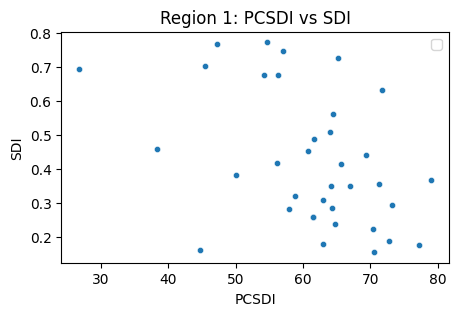

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


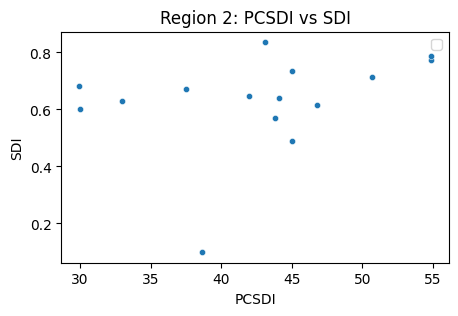

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


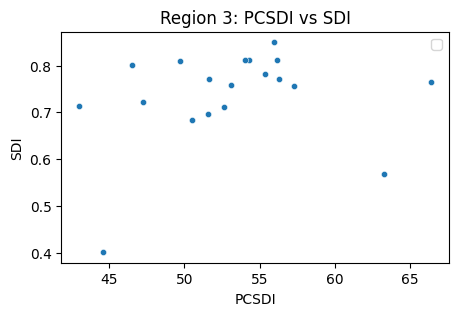

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


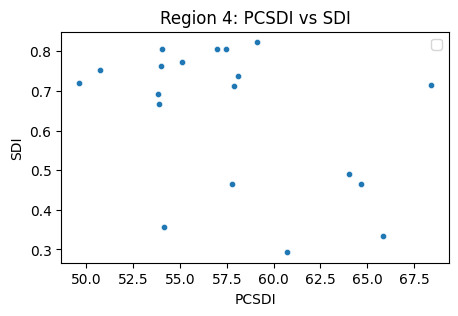

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


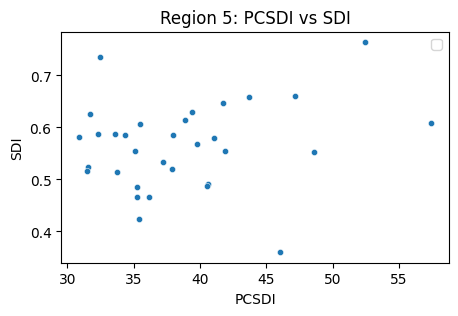

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


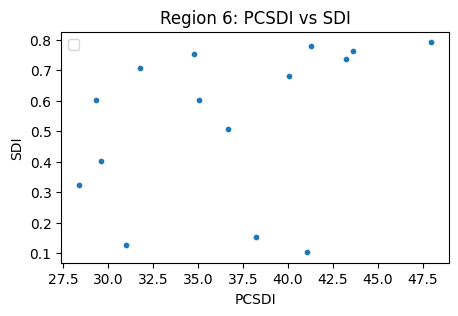

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

regions = [1, 2, 3, 4, 5, 6]

for region in regions:
    plt.figure(figsize=(5, 3))
    group_country = PCSDI_SDI.loc[PCSDI_SDI['GROUP'] == region]

    
    sns.scatterplot(x=group_country['PCSDI'], y=group_country['SDI'], s = 20)

    plt.title(f'Region {region}: PCSDI vs SDI')
    plt.xlabel('PCSDI')
    plt.ylabel('SDI')
    plt.legend()
    plt.show()


# Data Cleaning!

In [21]:
columns_series = pd.Series(BTI_all_years.columns)

# Define the regex pattern
pattern = r'Q(1[0-7]|[1-9])\s*\|\s*'


# First, find the column names that match the pattern
matching_columns = BTI_all_years_SDI.columns[BTI_all_years_SDI.columns.str.contains(pattern)]

# Create a list of columns to keep, explicitly including 'Year' and 'Country'
columns_to_keep = ['Year', 'Country', 'Region', 'SDI'] + matching_columns.tolist()
# Filter the DataFrame to keep only the desired columns
important_indices = BTI_all_years_SDI[columns_to_keep]
important_indices = important_indices.iloc[:, :-1]
important_indices

/var/folders/c4/nh07n52n3zb_f772q902yfv00000gn/T/ipykernel_17529/2958264710.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  matching_columns = BTI_all_years_SDI.columns[BTI_all_years_SDI.columns.str.contains(pattern)]


Year      Country  Region    SDI   Q1 | Stateness   
0    2018  Afghanistan       7  0.551             3.75  \
1    2016  Afghanistan       7  0.551             3.75   
2    2014  Afghanistan       7  0.551              3.5   
3    2012  Afghanistan       7  0.551             3.25   
4    2010  Afghanistan       7  0.551             2.75   
..    ...          ...     ...    ...              ...   
595  2018     Zimbabwe       5  0.615                7   
596  2016     Zimbabwe       5  0.615             7.25   
597  2014     Zimbabwe       5  0.615             7.25   
598  2012     Zimbabwe       5  0.615              7.5   
599  2010     Zimbabwe       5  0.615                7   

      Q2 | Political Participation   Q3 | Rule of Law   
0                              3.5                2.5  \
1                              3.5                2.5   
2                             3.25               2.75   
3                             3.25               2.25   
4                                4               2.25   
..                             ...                ...   
595                           3.25               2.75   
596                            3.5               3.25   
597                            3.5                3.5   
598                           3.25                  3   
599                              3               2.75   

      Q4 | Stability of Democratic Institutions   
0                                             3  \
1                                             3   
2                                             3   
3                                             3   
4                                             3   
..                                          ...   
595                                         2.5   
596                                           3   
597                                           3   
598                                           3   
599                                           2   

      Q5 | Political and Social Integration   
0                                  2.333333  \
1                                  2.333333   
2                                  2.333333   
3                                         2   
4                                         2   
..                                      ...   
595                                3.666667   
596                                       4   
597                                4.666667   
598                                       5   
599                                       5   

      Q6 | Level of Socioeconomic Development  ...   
0                                           1  ...  \
1                                           1  ...   
2                                           1  ...   
3                                           1  ...   
4                                           1  ...   
..                                        ...  ...   
595                                         2  ...   
596                                         3  ...   
597                                         3  ...   
598                                         3  ...   
599                                         2  ...   

      Q8 | Monetary and Fiscal Stability   Q9 | Private Property   
0                                      4                     3.5  \
1                                      5                       3   
2                                      5                     3.5   
3                                      5                     3.5   
4                                    4.5                     3.5   
..                                   ...                     ...   
595                                  3.5                     2.5   
596                                  5.5                     2.5   
597                                    5                     2.5   
598                                    3                     2.5   
599                                    1        

In [22]:
#Deal wth null values

In [23]:
#Check that granularity is correct
important_indices.loc[important_indices['Country'] == 'Zimbabwe']
#Create an array of column names
important_indices_array = important_indices.columns[3:-1]

# Regression!

In [64]:
#sort by region
important_indices = important_indices.sort_values(by = 'Region')
important_indices

Year      Country  Region    SDI    Q1 | Stateness   
459  2010      Romania       1  0.692              9.25  \
366  2016   Montenegro       1  0.464              9.25   
365  2018   Montenegro       1  0.464              9.00   
234  2010      Hungary       1  0.728             10.00   
498  2012     Slovenia       1  0.455              9.75   
..    ...          ...     ...    ...               ...   
118  2012        China       7  0.461              8.75   
237  2014        India       7  0.696              7.75   
116  2016        China       7  0.461              8.75   
440  2018  Philippines       7  0.773              6.50   
0    2018  Afghanistan       7  0.551              3.75   

       Q2 | Political Participation    Q3 | Rule of Law   
459                            9.25                8.25  \
366                            7.75                7.00   
365                            7.50                7.00   
234                           10.00                9.00   
498                            9.75                9.50   
..                              ...                 ...   
118                            1.75                2.25   
237                            9.25                7.50   
116                            1.75                2.25   
440                            6.75                5.50   
0                              3.50                2.50   

       Q4 | Stability of Democratic Institutions   
459                                          8.5  \
366                                          8.0   
365                                          7.0   
234                                          8.5   
498                                         10.0   
..                                           ...   
118                                          1.5   
237                                          8.5   
116                                          1.0   
440                                          7.0   
0                                            3.0   

       Q5 | Political and Social Integration   
459                                 7.250000  \
366                                 7.250000   
365                                 7.250000   
234                                 8.750000   
498                                 9.250000   
..                                       ...   
118                                 2.333333   
237                                 7.500000   
116                                 2.666667   
440                                 5.750000   
0                                   2.333333   

       Q6 | Level of Socioeconomic Development  ...   
459                                        7.0  ...  \
366                                        7.0  ...   
365                                        7.0  ...   
234                                        9.0  ...   
498                                       10.0  ...   
..                                         ...  ...   
118                                        5.0  ...   
237                                        4.0  ...   
116                                        5.0  ...   
440                                        5.0  ...   
0                                          1.0  ...   

       Q8 | Monetary and Fiscal Stability    Q9 | Private Property   
459                                   9.0                      9.0  \
366                                   7.5                      8.0   
365                                   7.5                      8.0   
234                                   8.0                     10.0   
498                                   9.5                      9.5   
..                                    ...                      ...   
118                                   7.0                      6.0   
237                                   7.5                      7.5   
116                                   7.5                      6.0   
440                     

# Regress each SDI on BTI for every region

In [25]:
#drop the non-numeric rows.
numeric_columns = important_indices.columns.difference(['Region', 'Year', 'Country'])
important_indices[numeric_columns] = important_indices[numeric_columns].apply(pd.to_numeric, errors='coerce')
important_indices.dropna(subset=numeric_columns, inplace=True)


BTI_SDI_all_year_lin_corr = {}


regions = [1, 2, 3, 4, 5, 6, 7]

# Exclude 'SDI', 'Region', 'Year', 'Country' from the analysis
important_indices_array = [col for col in important_indices.columns if col not in ['SDI', 'Region', 'Year', 'Country']]

for region in regions:
    # Filter the DataFrame for the current region
    group_country = important_indices.loc[important_indices['Region'] == region]
    
    
    # Initialize a dictionary for this region
    BTI_SDI_all_year_lin_corr[region] = {}
    
    for index in important_indices_array:
        X = group_country[[index]]
        y = group_country['SDI']
        
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
        
        
        model = LinearRegression()
        model.fit(X_train, y_train)
        
        
        predictions = model.predict(X_test)
        r_squared = r2_score(y_test, predictions)
        mse = mean_squared_error(y_test, predictions)
        rmse = sqrt(mse)
        coef = model.coef_
        
        # Store the results in the dictionary
        BTI_SDI_all_year_lin_corr[region][index] = {'R_squared': r_squared, 'RMSE': rmse, 'COEF': coef}

BTI_SDI_all_year_lin_corr
important_indices

Year         Country  Region    SDI    Q1 | Stateness   
459  2010         Romania       1  0.692              9.25  \
145  2018  Czech Republic       1  0.399             10.00   
146  2016  Czech Republic       1  0.399             10.00   
147  2014  Czech Republic       1  0.399             10.00   
148  2012  Czech Republic       1  0.399             10.00   
..    ...             ...     ...    ...               ...   
244  2010       Indonesia       7  0.768              6.75   
285  2018            Laos       7  0.658              8.25   
286  2016            Laos       7  0.658              8.50   
238  2012           India       7  0.696              8.25   
0    2018     Afghanistan       7  0.551              3.75   

       Q2 | Political Participation    Q3 | Rule of Law   
459                            9.25                8.25  \
145                           10.00                9.25   
146                            9.75                9.25   
147                           10.00                9.25   
148                           10.00                9.25   
..                              ...                 ...   
244                            7.75                6.75   
285                            1.00                2.00   
286                            1.00                2.00   
238                            9.50                7.50   
0                              3.50                2.50   

       Q4 | Stability of Democratic Institutions   
459                                          8.5  \
145                                          9.0   
146                                          9.5   
147                                         10.0   
148                                         10.0   
..                                           ...   
244                                          7.0   
285                                          1.0   
286                                          1.0   
238                                          8.5   
0                                            3.0   

       Q5 | Political and Social Integration   
459                                 7.250000  \
145                                 8.750000   
146                                 8.750000   
147                                 8.750000   
148                                 9.000000   
..                                       ...   
244                                 6.750000   
285                                 2.333333   
286                                 2.000000   
238                                 7.250000   
0                                   2.333333   

       Q6 | Level of Socioeconomic Development  ...   
459                                        7.0  ...  \
145                                       10.0  ...   
146                                       10.0  ...   
147                                       10.0  ...   
148                                       10.0  ...   
..                                         ...  ...   
244                                        6.0  ...   
285                                        4.0  ...   
286                                        4.0  ...   
238                                        4.0  ...   
0                                          1.0  ...   

       Q8 | Monetary and Fiscal Stability    Q9 | Private Property   
459                                   9.0                      9.0  \
145                                  10.0                     10.0   
146                                   9.5                     10.0   
147                                   9.5                     10.0   
148                                   9.5                     10.0   
..                                    ...                      ...   
244                                   7.0                      6.0   
285                                   6.5                      4.0   
286                                   6.0                 

## Filtered results

In [26]:
filtered_BTI_SDI_results = {}

for region, indices in BTI_SDI_all_year_lin_corr.items():
    filtered_BTI_SDI_results[region] = {}
    for index, metrics in indices.items():
        r_squared = metrics['R_squared']
        # Apply the filtering conditions
        if r_squared > 0.3 or r_squared < 0:
            filtered_BTI_SDI_results[region][index] = metrics

# Now, 'filtered_BTI_SDI_results' contains only the indices that meet the specified R-squared criteria for each region.
filtered_BTI_SDI_results

{1: {'  Q1 | Stateness': {'R_squared': -0.19790441034458728,
   'RMSE': 0.19957847445189145,
   'COEF': array([-0.11723462])},
  '  Q2 | Political Participation': {'R_squared': 0.30116482883211315,
   'RMSE': 0.1524368598138595,
   'COEF': array([-0.14193271])},
  '  Q4 | Stability of Democratic Institutions': {'R_squared': 0.3871540698565511,
   'RMSE': 0.14275070765862083,
   'COEF': array([-0.08183333])},
  '  Q8 | Monetary and Fiscal Stability': {'R_squared': 0.3790144704931697,
   'RMSE': 0.1436955624960381,
   'COEF': array([-0.13159974])},
  '  Q12 | Sustainability': {'R_squared': -0.042841509883331685,
   'RMSE': 0.18621376092757233,
   'COEF': array([-0.08277269])},
  '  Q14 | Steering Capability': {'R_squared': 0.3191957000222233,
   'RMSE': 0.15045747243235563,
   'COEF': array([-0.10854064])},
  '  Q15 | Resource Efficiency': {'R_squared': 0.49669343269789157,
   'RMSE': 0.12936563222751668,
   'COEF': array([-0.10722438])},
  '  Q17 | International Cooperation': {'R_square

## Visualization of SDI vs PCSDI

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


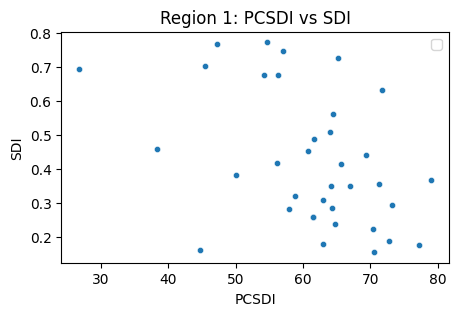

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


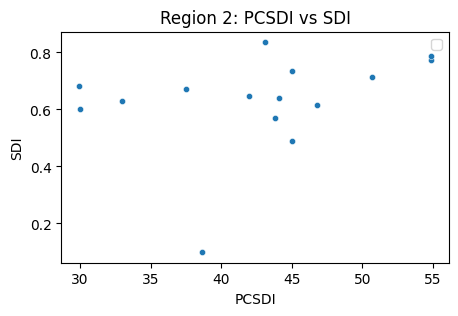

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


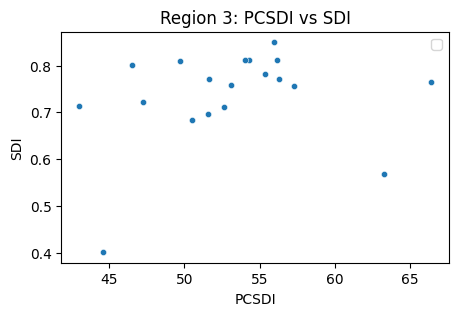

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


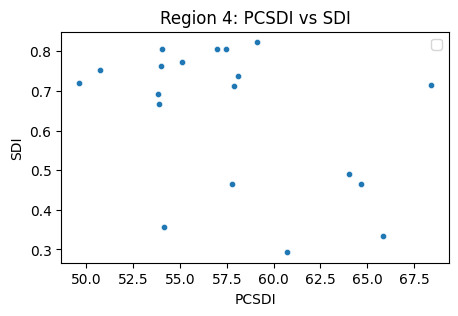

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


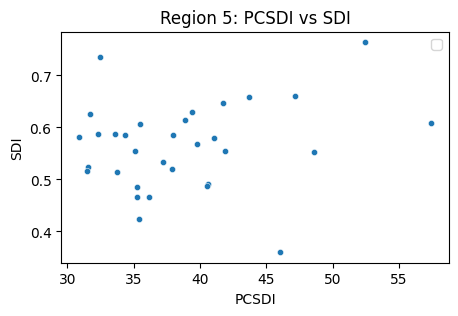

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


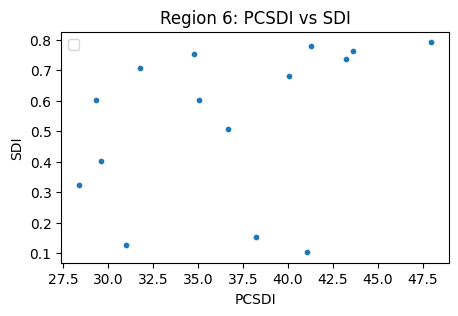

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

regions = [1, 2, 3, 4, 5, 6]

for region in regions:
    plt.figure(figsize=(5, 3))
    group_country = PCSDI_SDI.loc[PCSDI_SDI['GROUP'] == region]

    
    sns.scatterplot(x=group_country['PCSDI'], y=group_country['SDI'], s = 20)

    plt.title(f'Region {region}: PCSDI vs SDI')
    plt.xlabel('PCSDI')
    plt.ylabel('SDI')
    plt.legend()
    plt.show()


## Visualization of SDI vs BTI

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


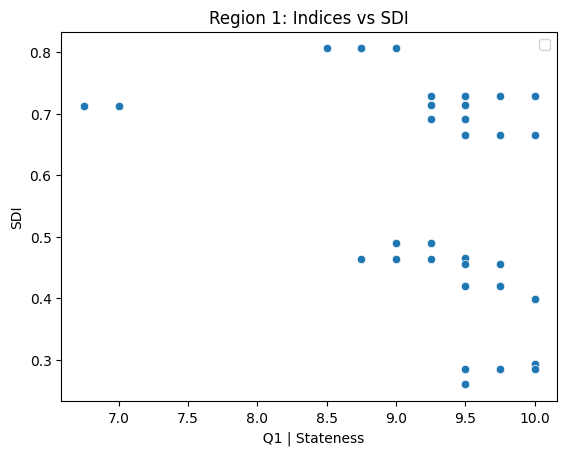

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


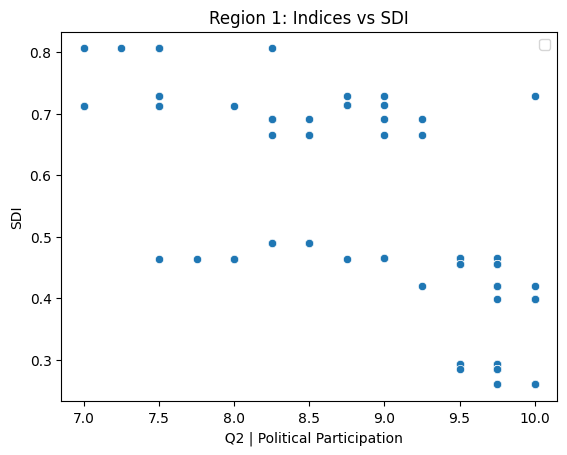

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


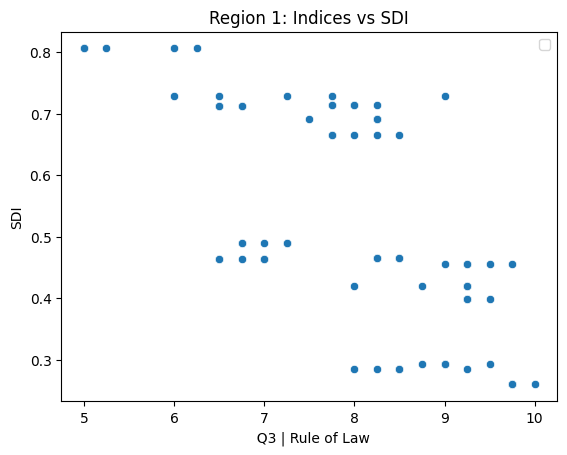

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


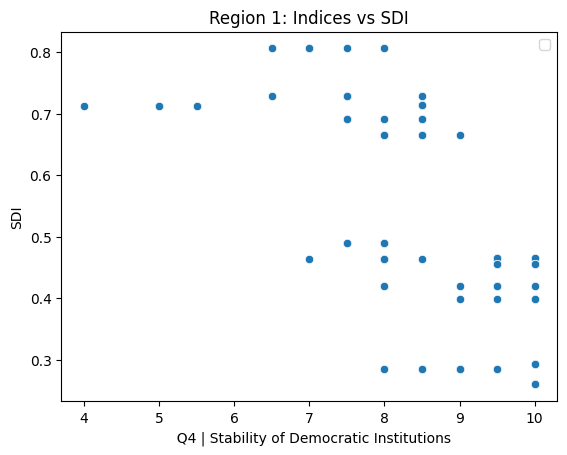

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


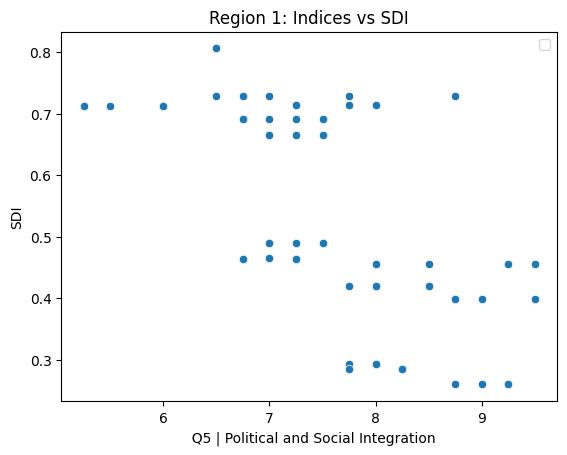

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


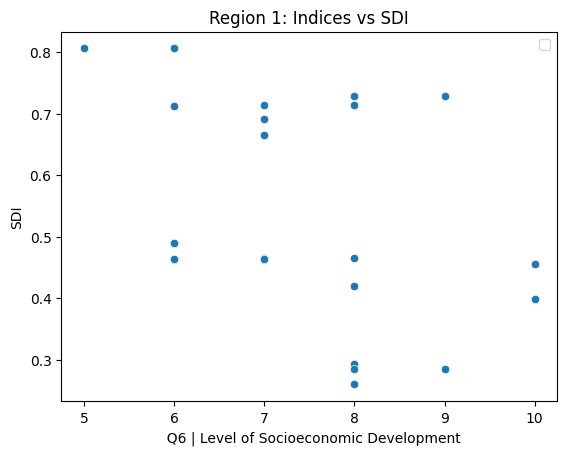

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


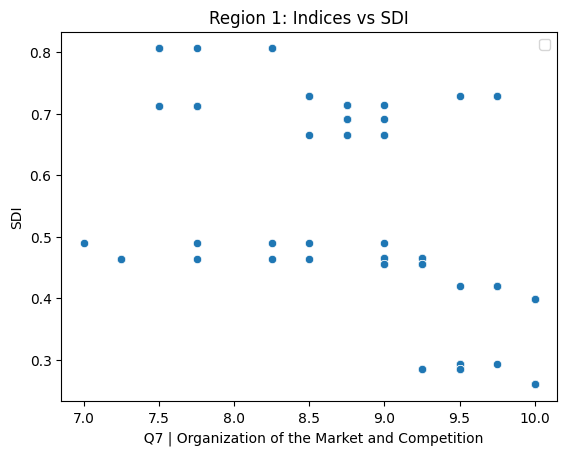

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


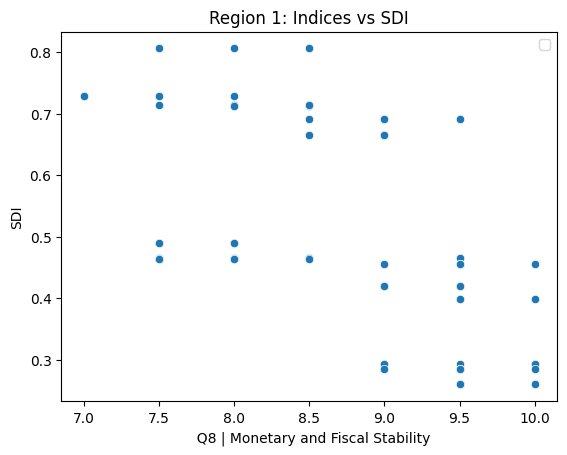

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


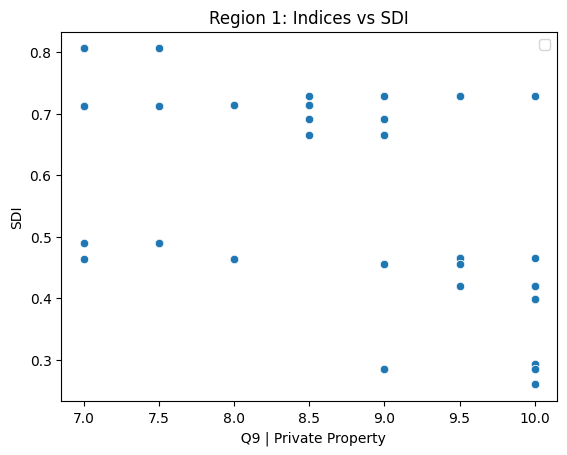

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


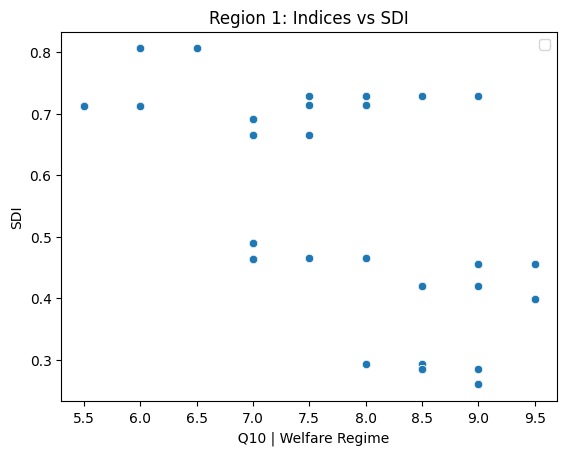

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


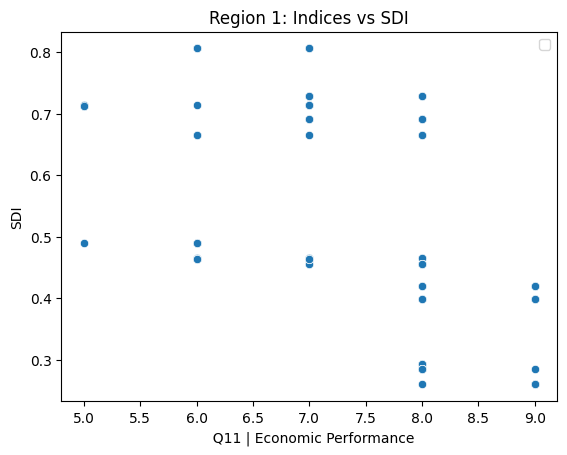

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


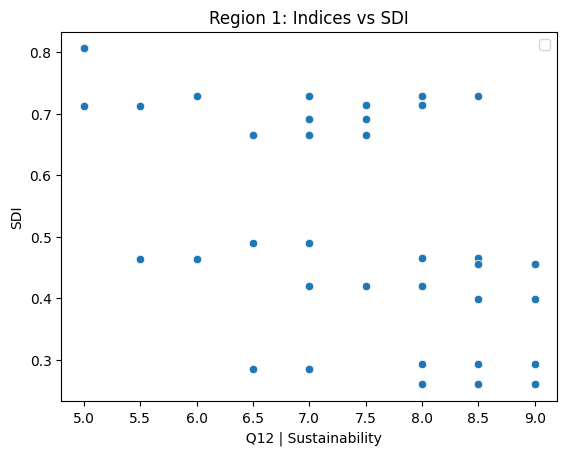

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


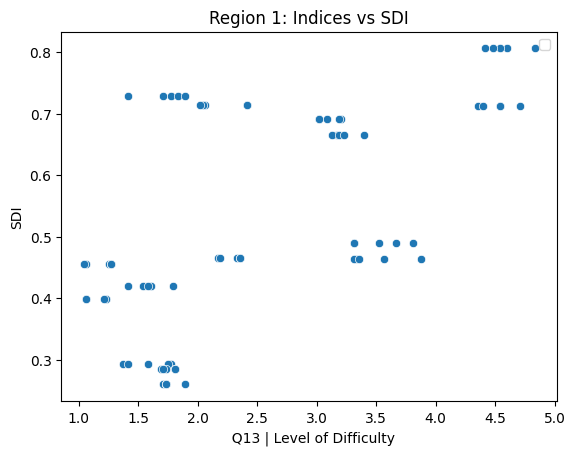

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


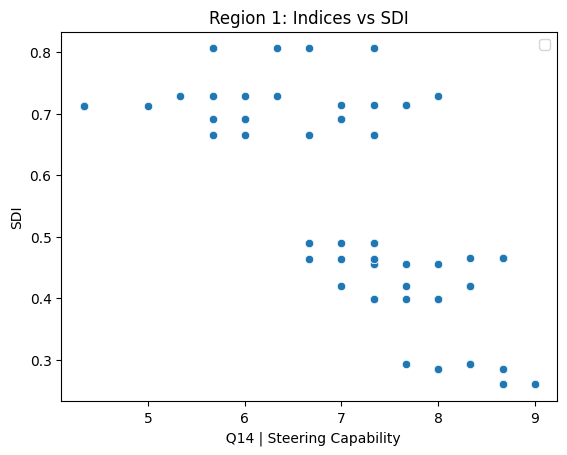

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


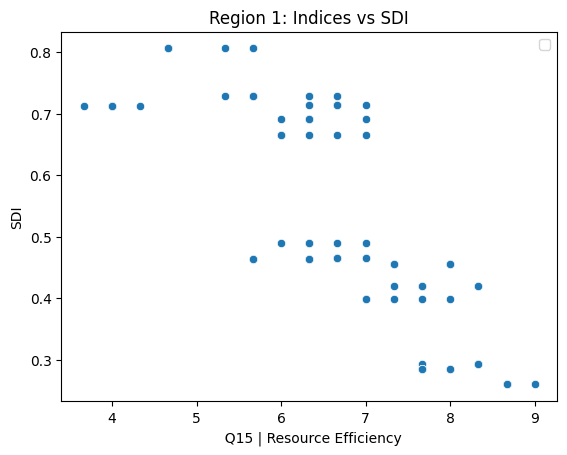

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


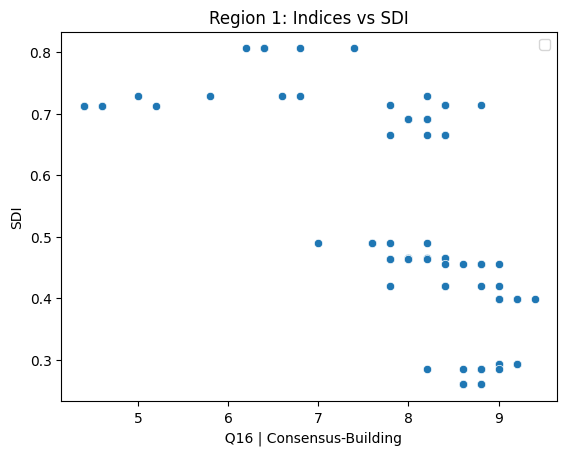

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


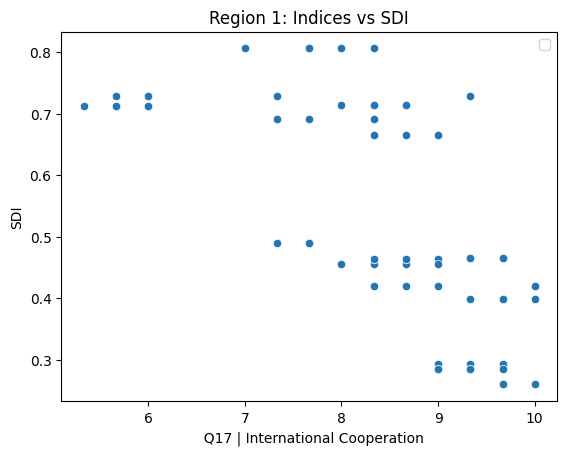

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


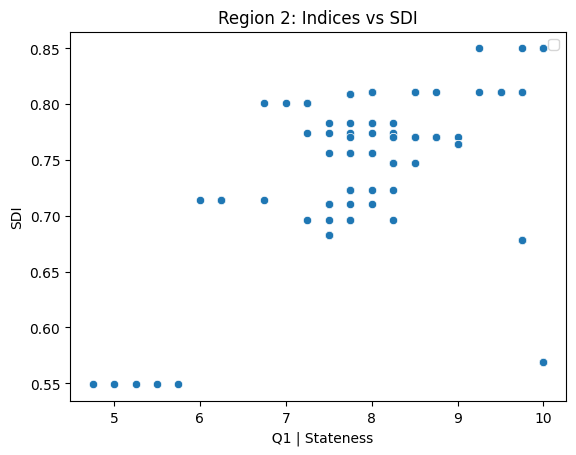

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


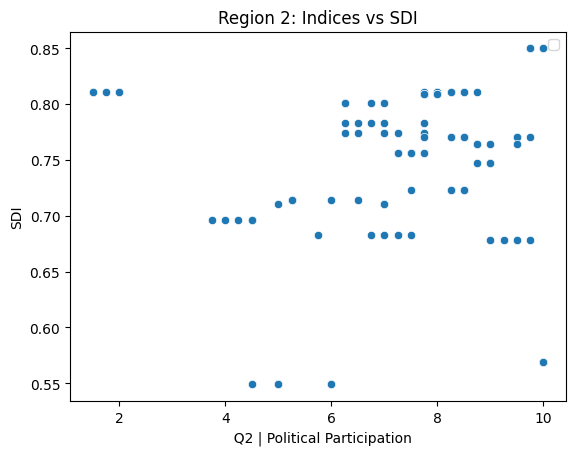

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


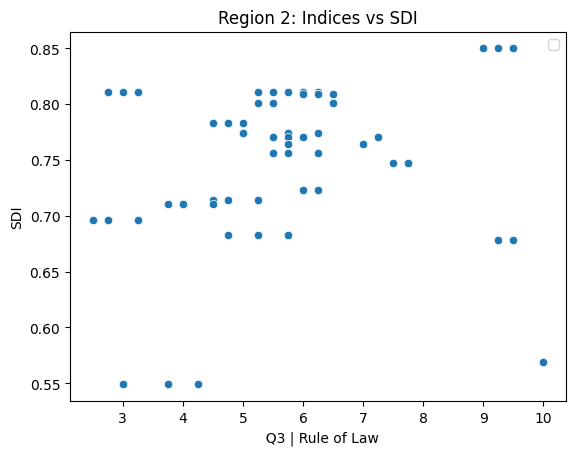

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


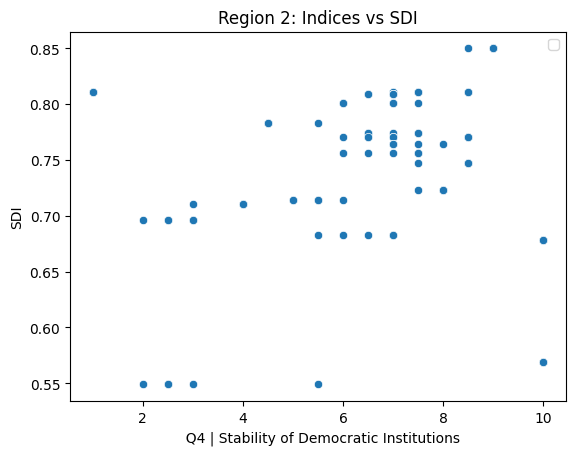

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


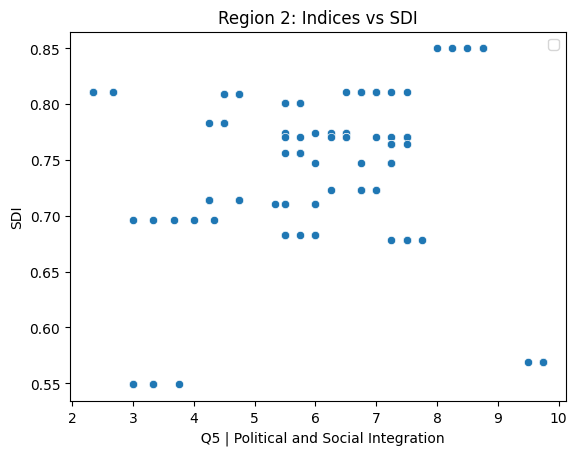

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


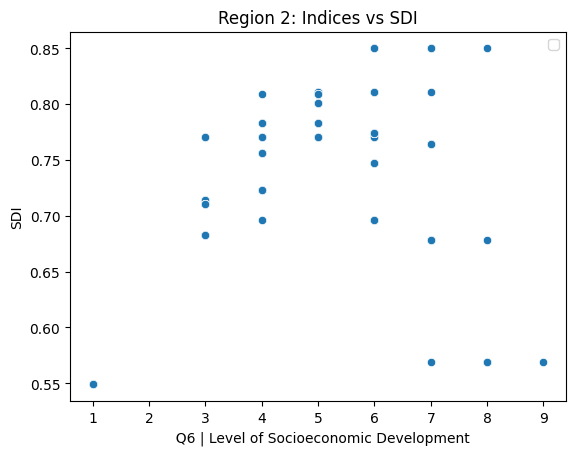

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


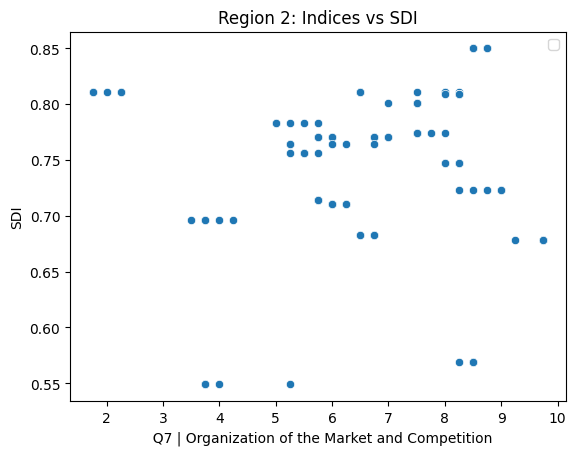

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


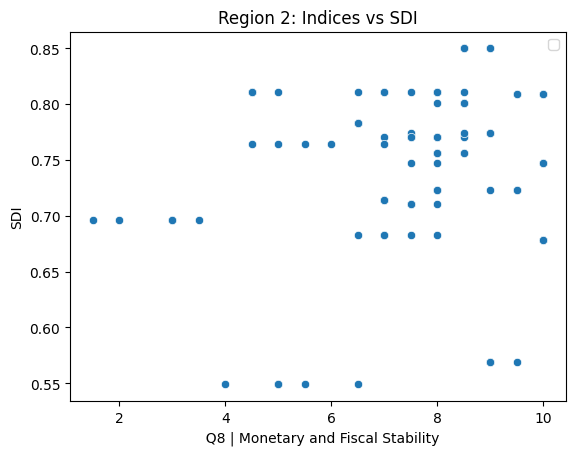

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


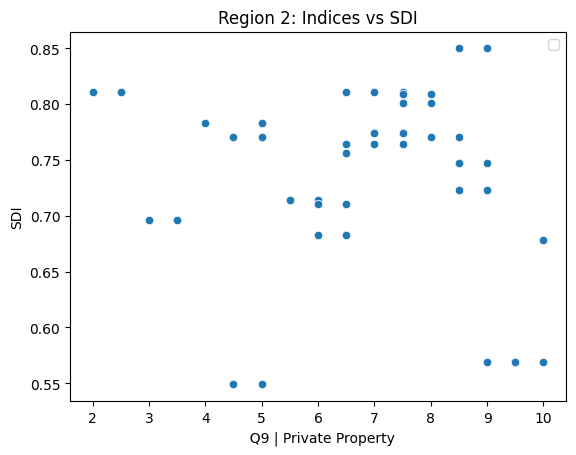

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


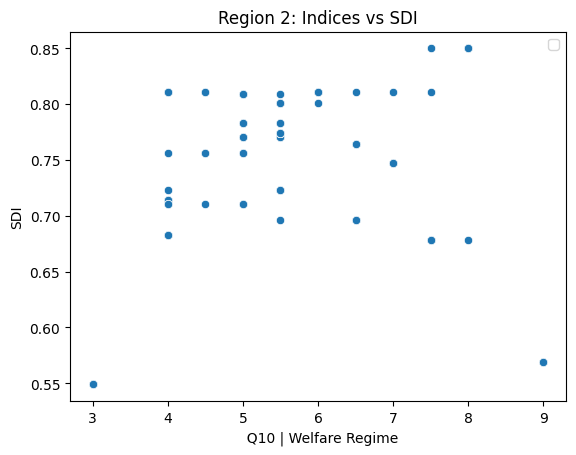

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


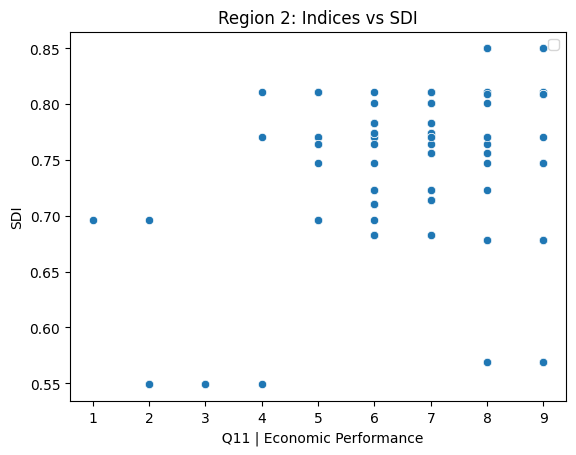

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


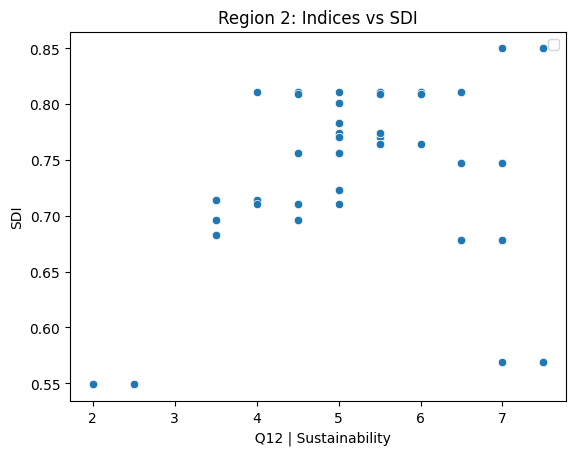

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


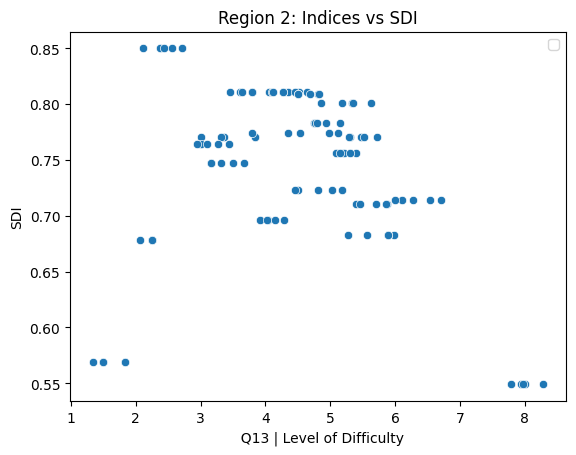

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


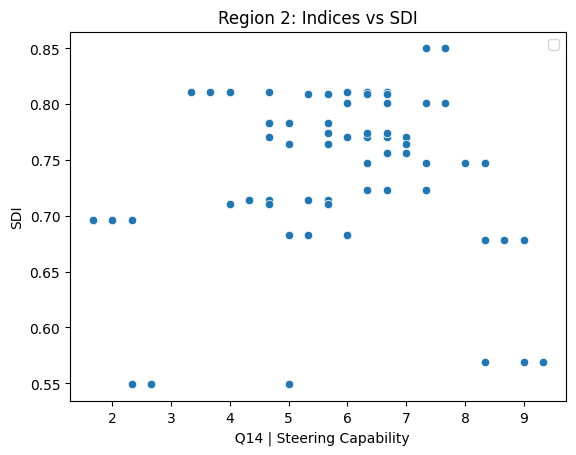

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


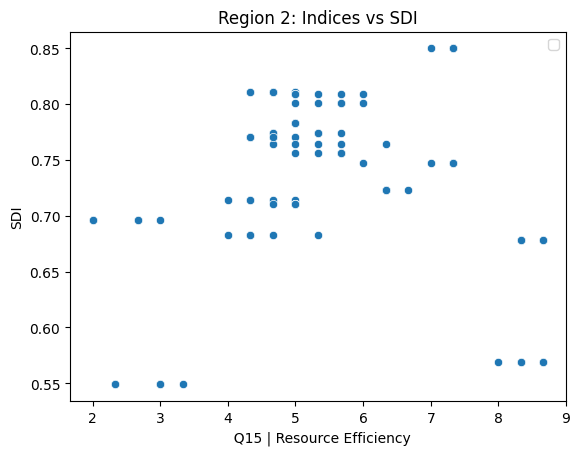

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


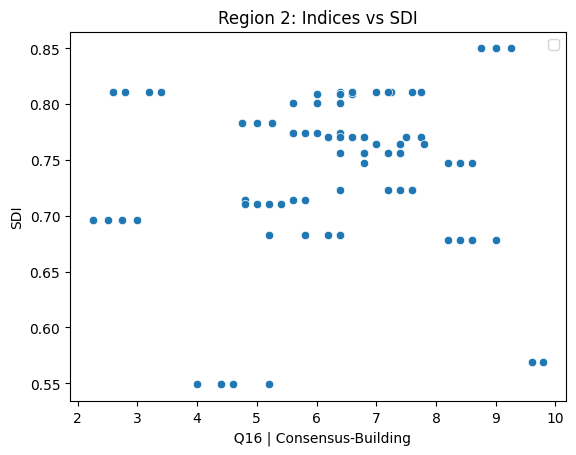

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


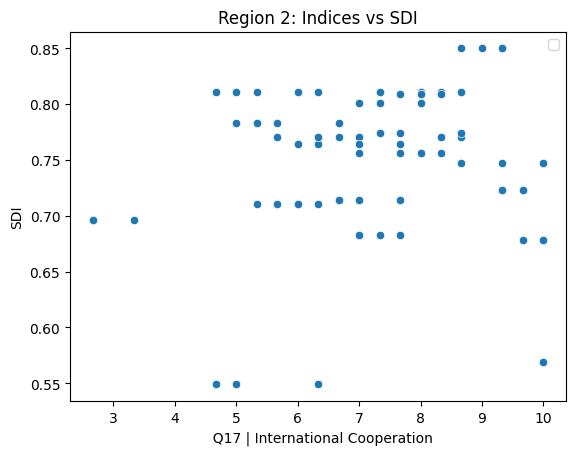

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


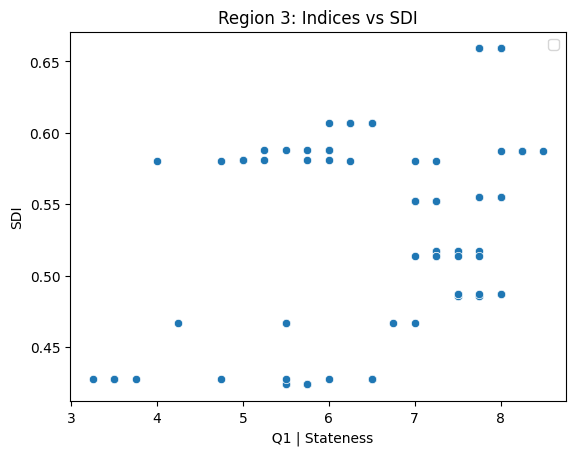

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


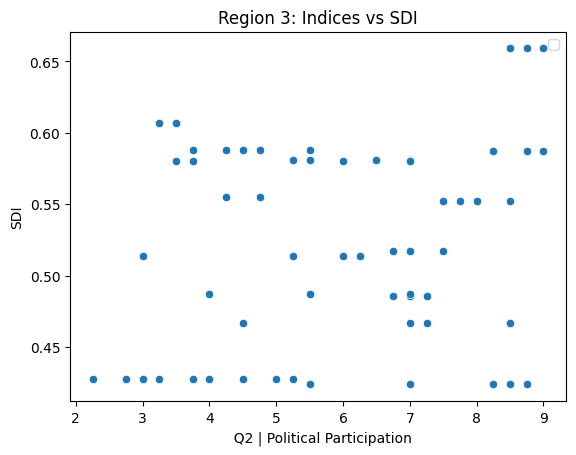

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


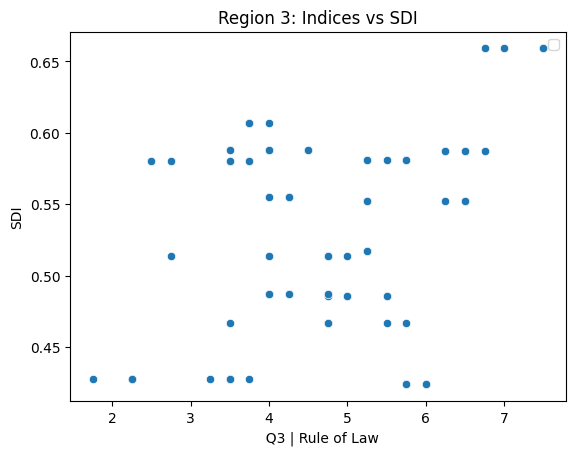

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


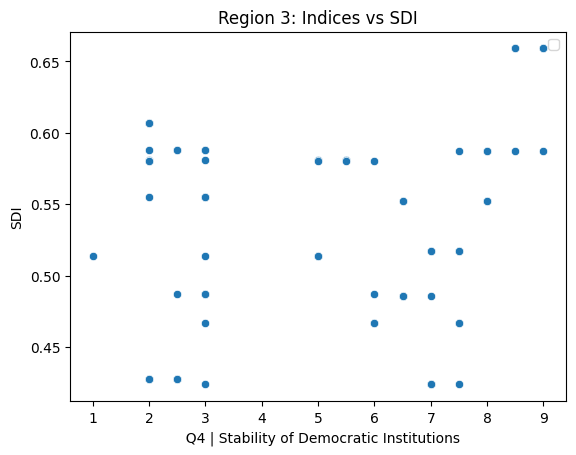

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


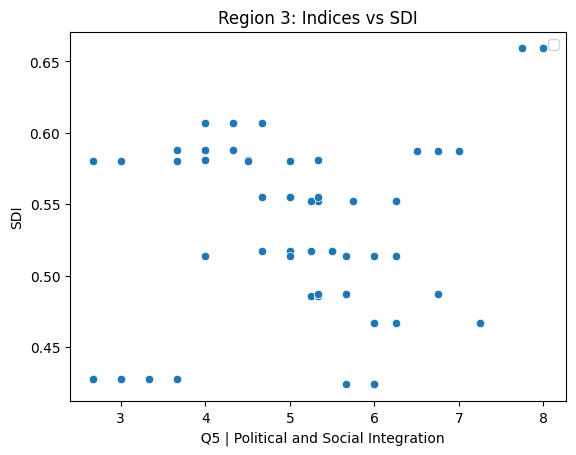

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


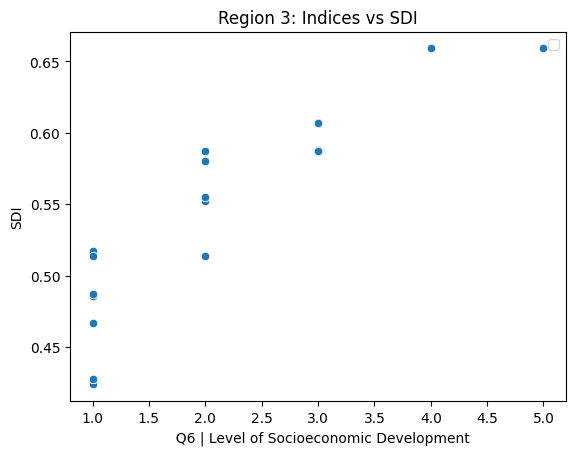

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


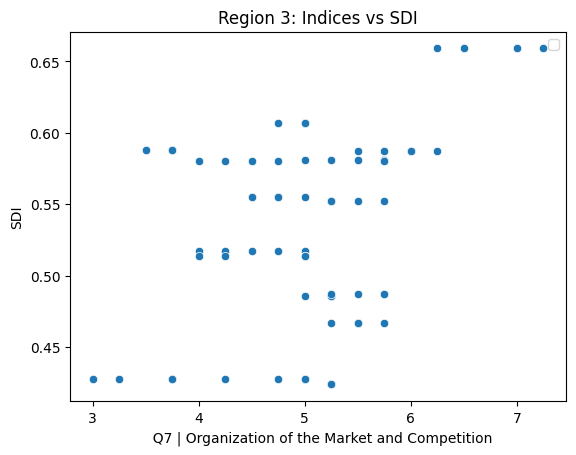

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


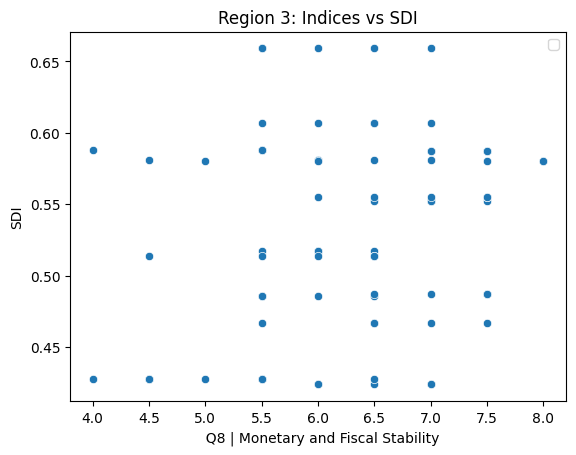

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


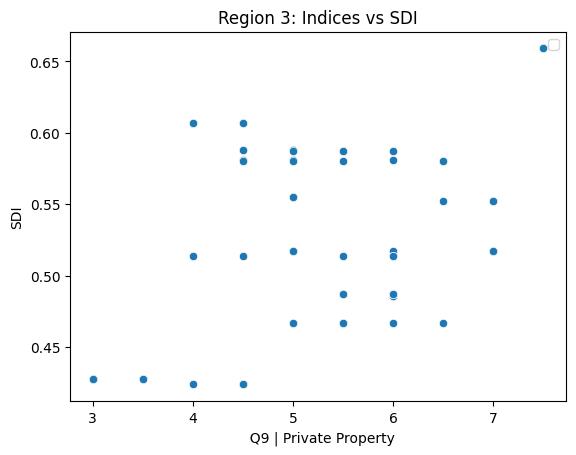

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


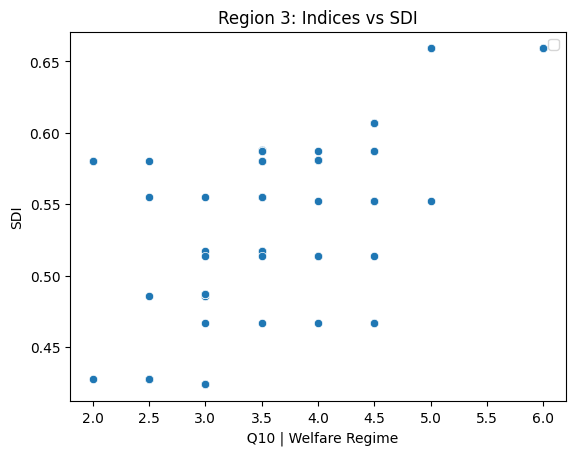

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


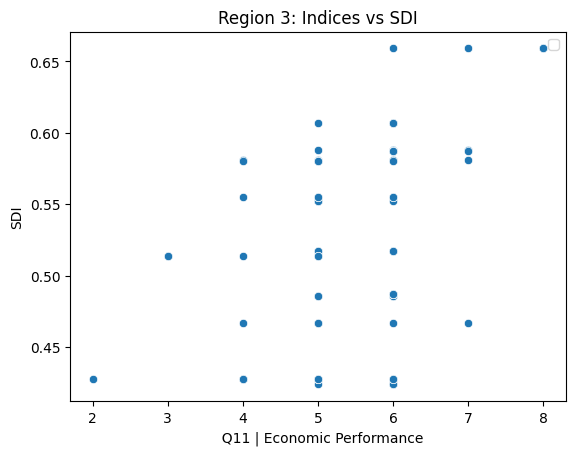

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


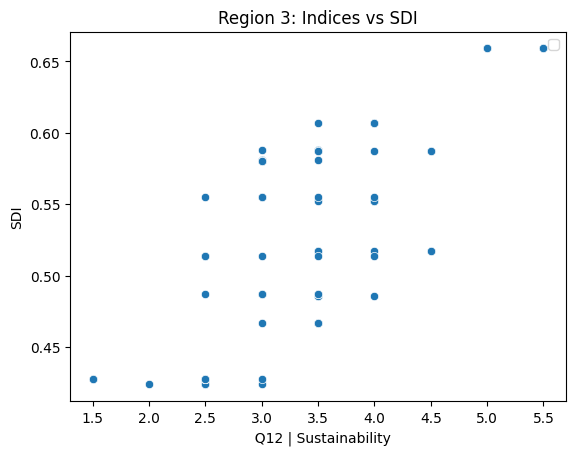

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


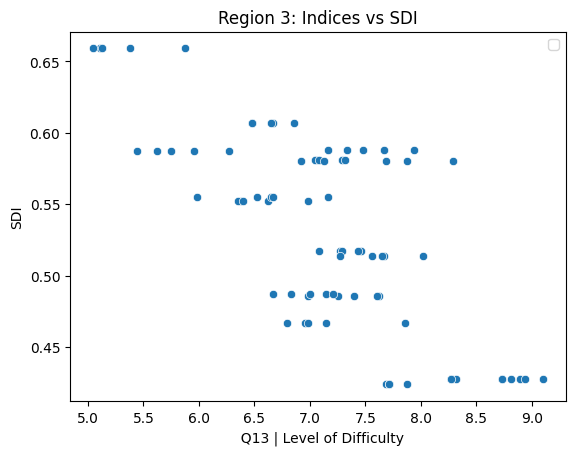

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


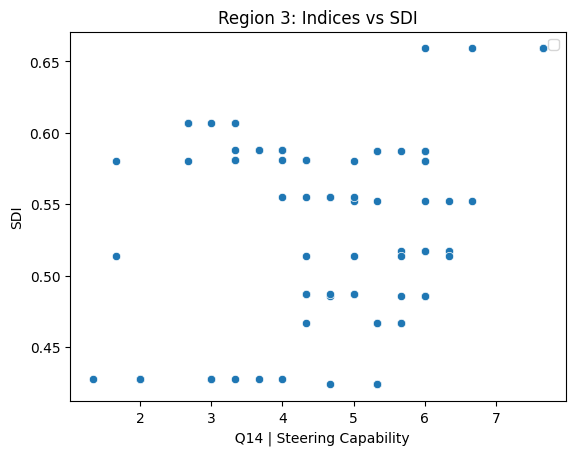

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


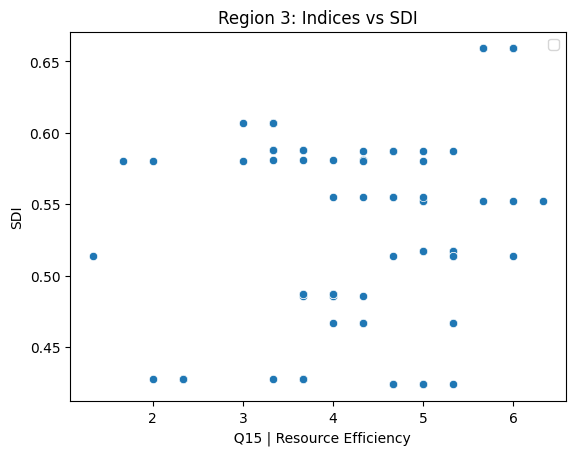

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


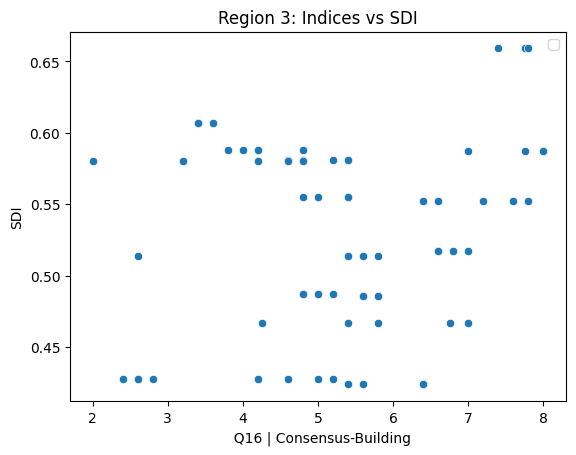

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


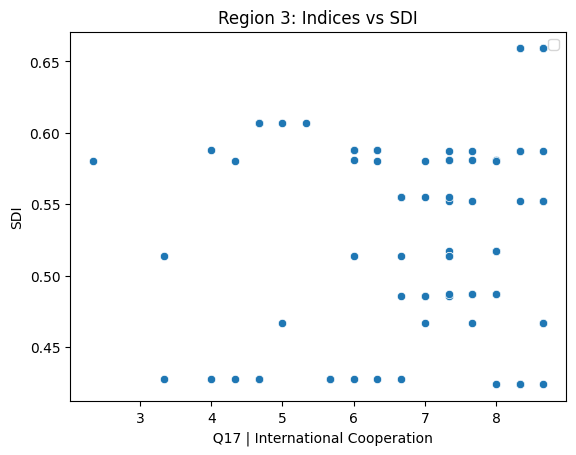

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


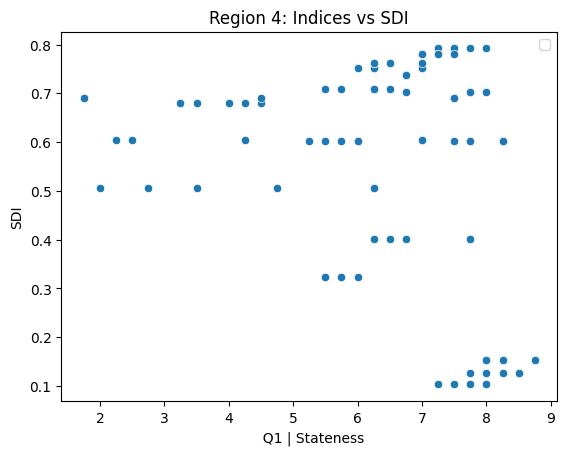

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


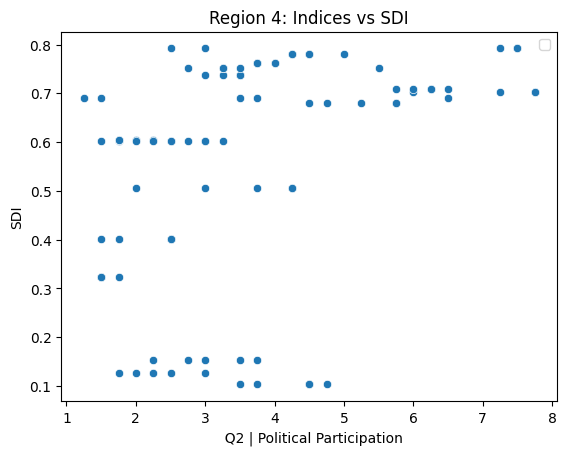

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


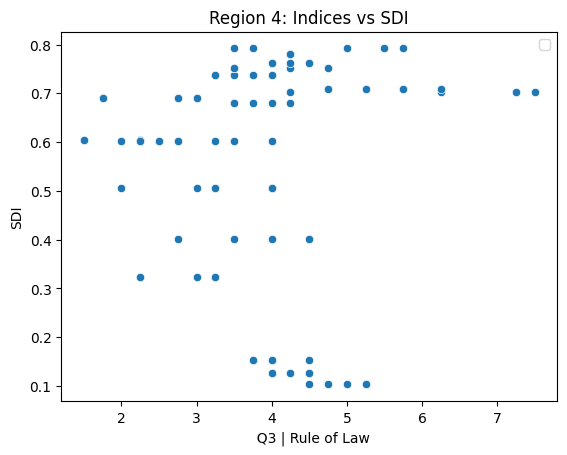

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


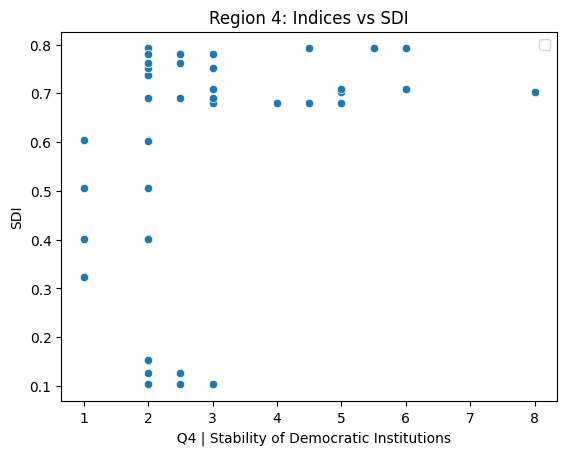

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


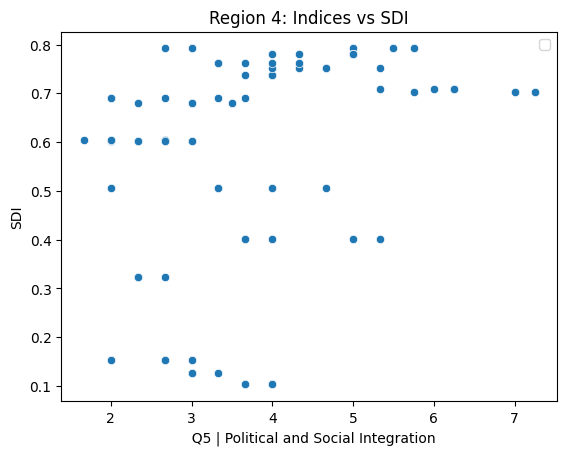

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


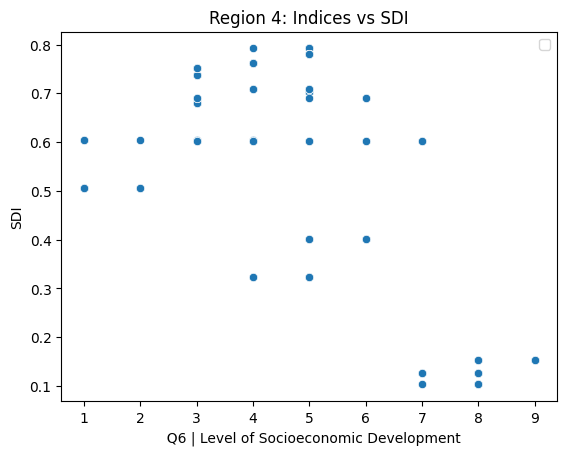

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


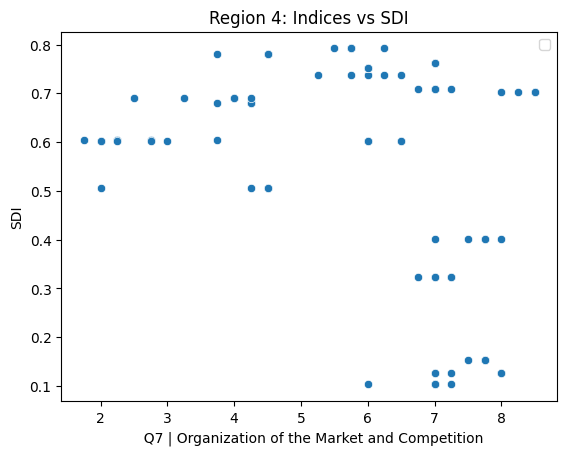

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


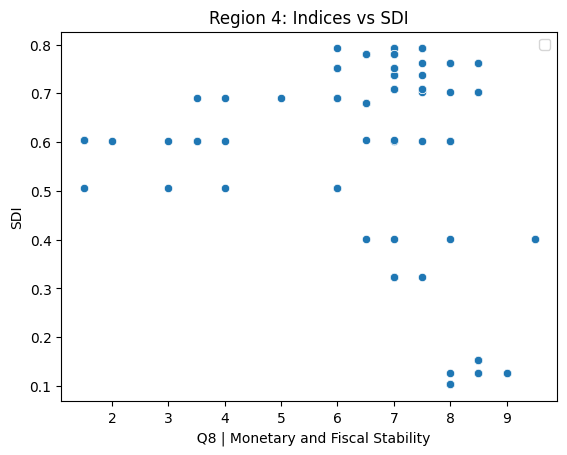

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


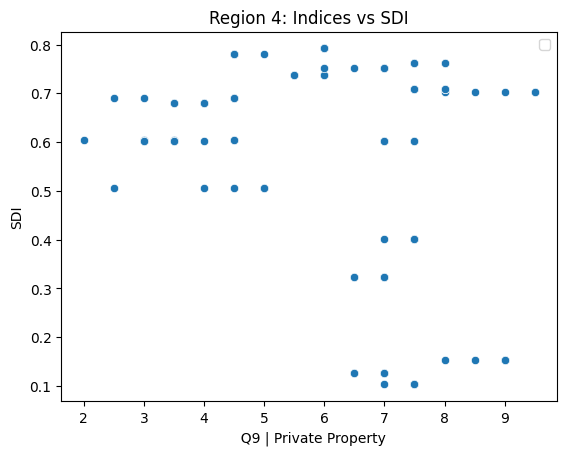

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


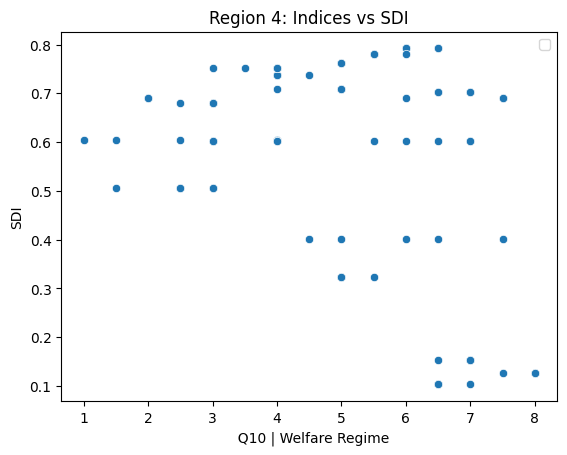

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


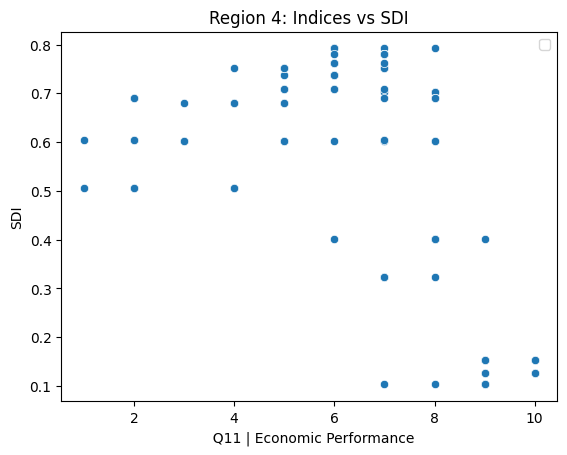

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


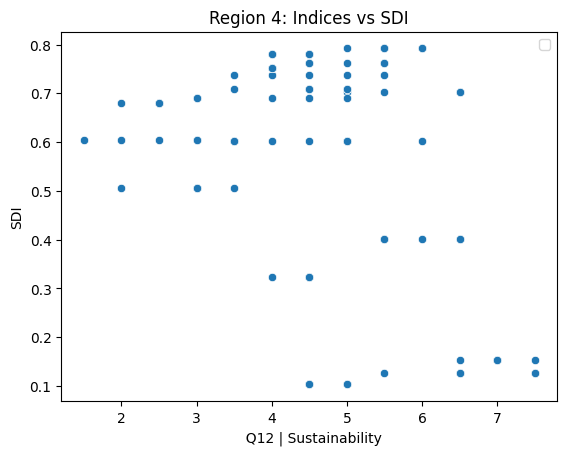

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


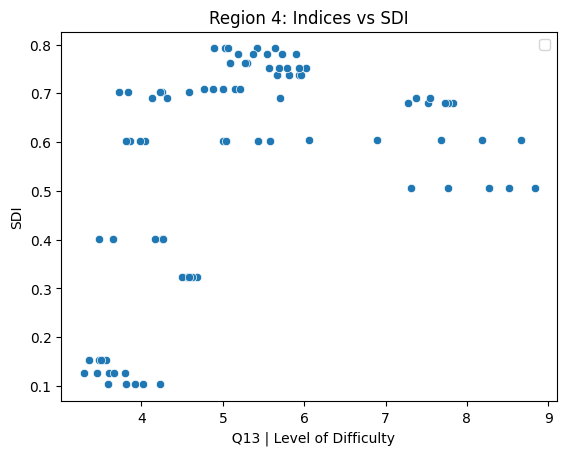

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


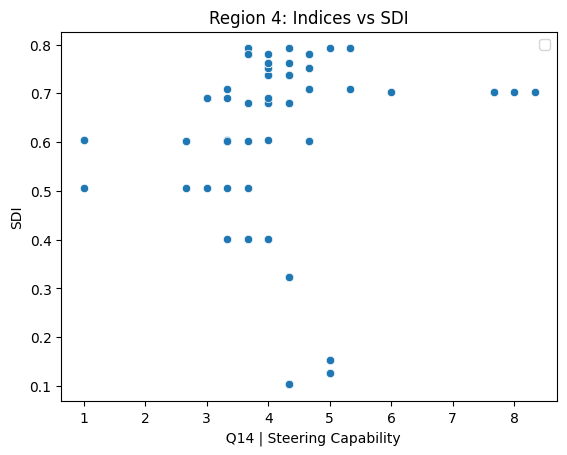

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


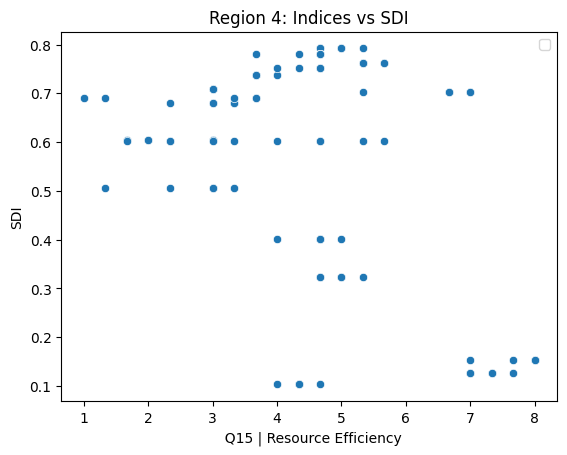

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


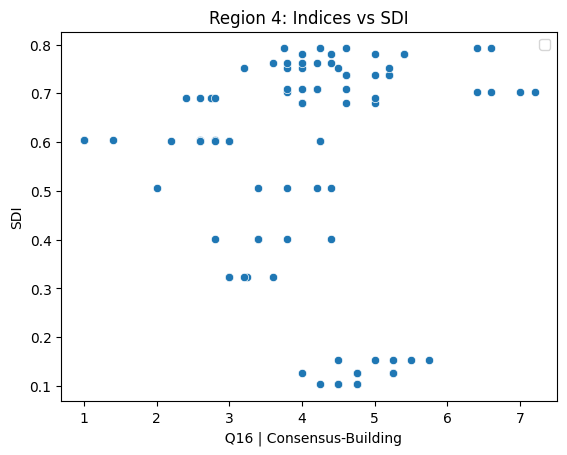

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


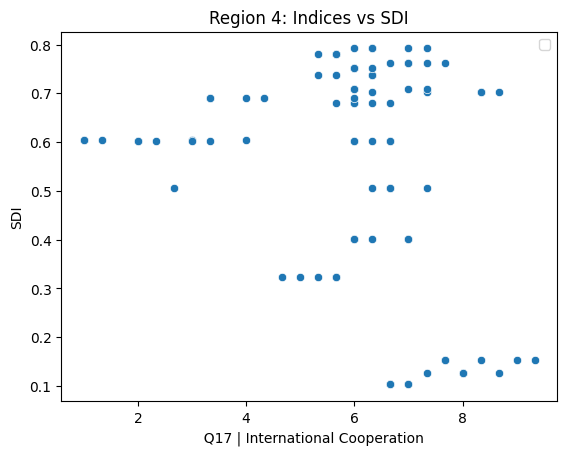

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


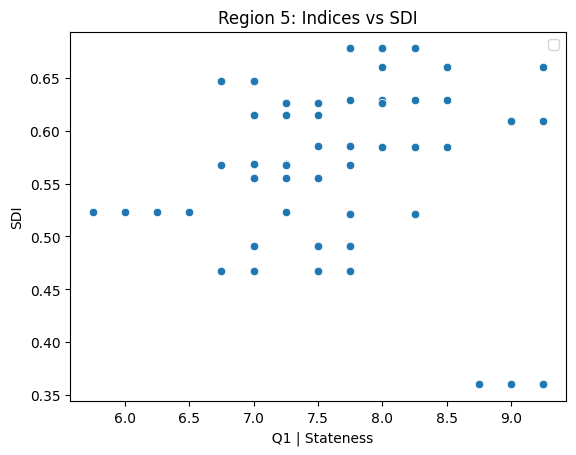

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


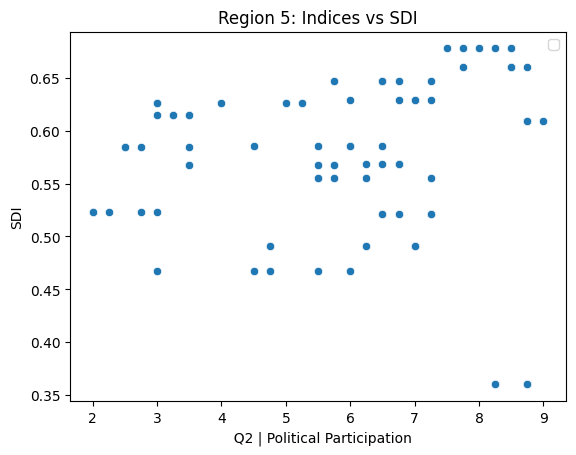

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


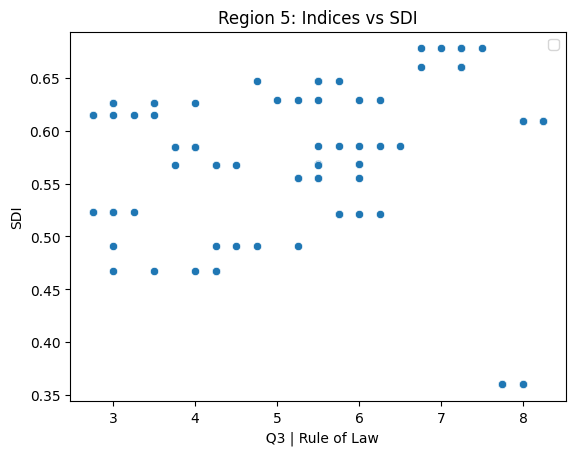

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


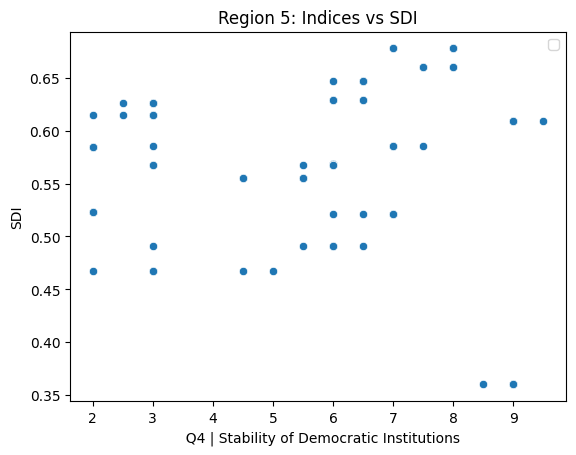

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


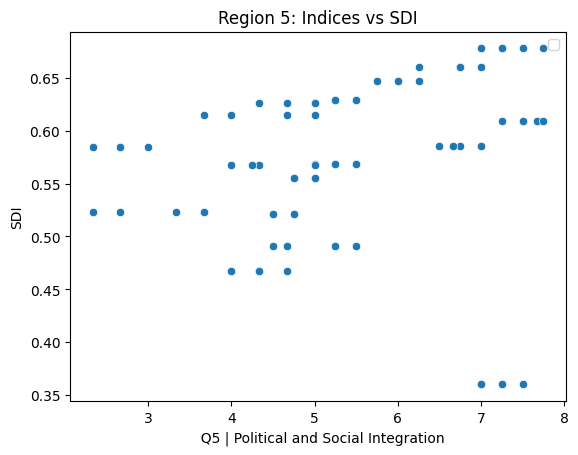

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


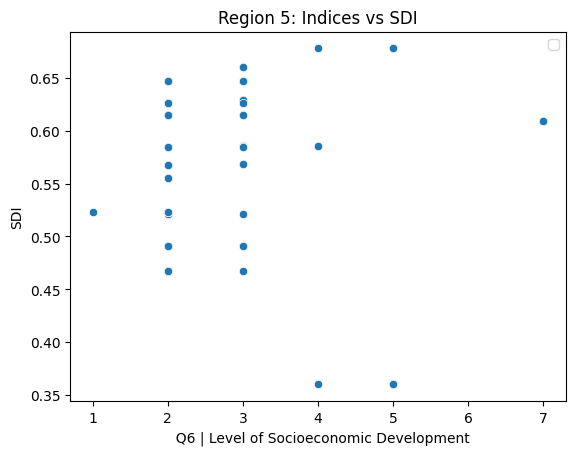

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


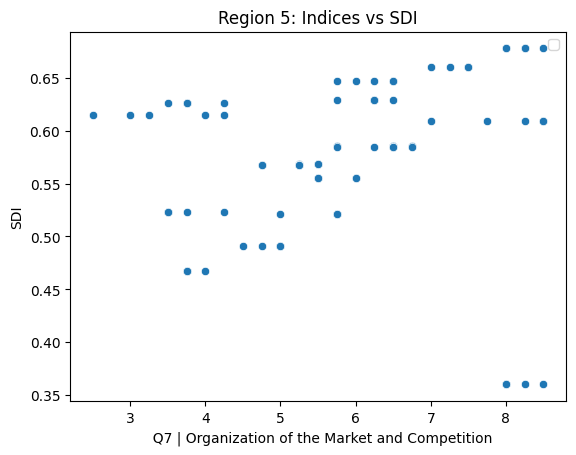

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


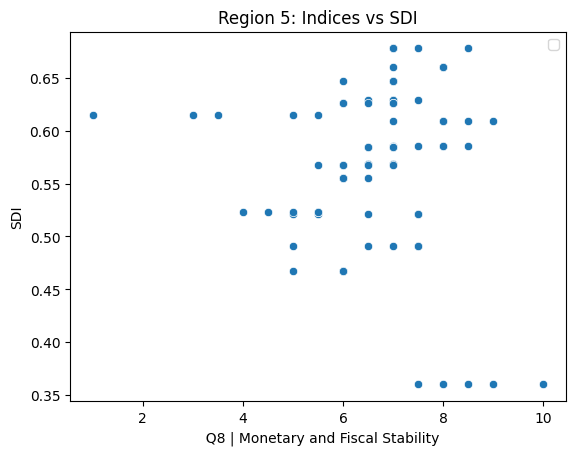

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


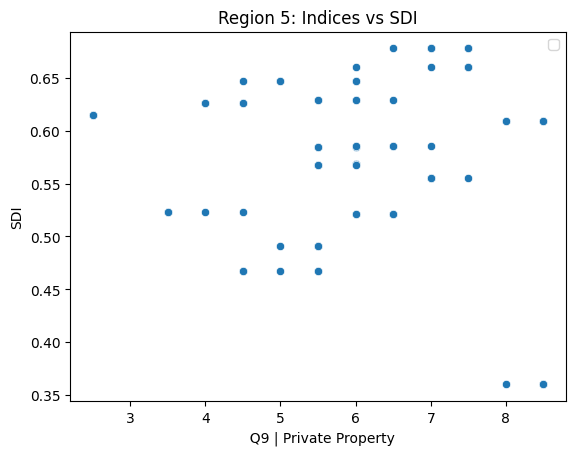

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


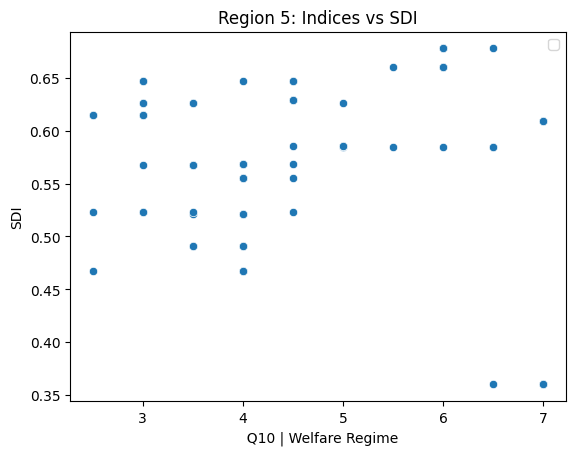

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


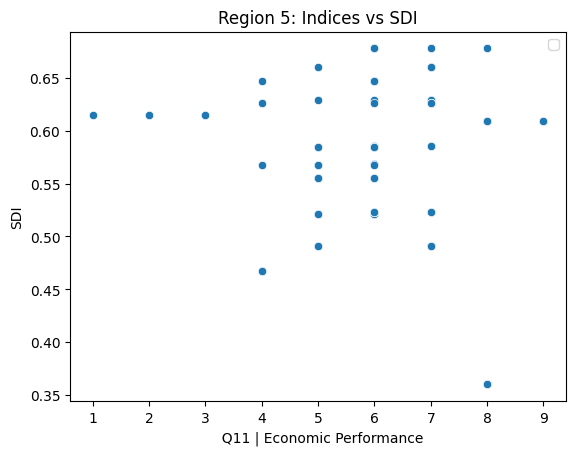

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


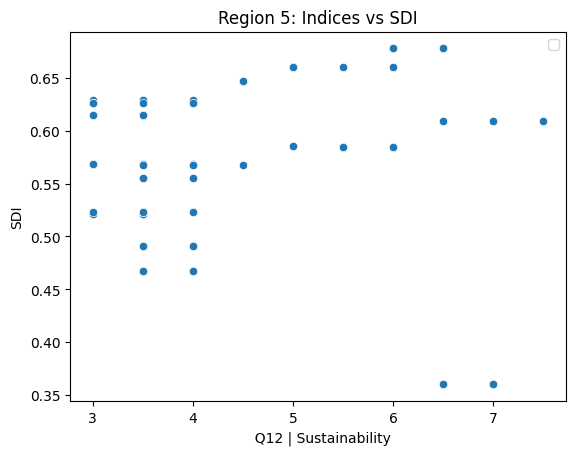

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


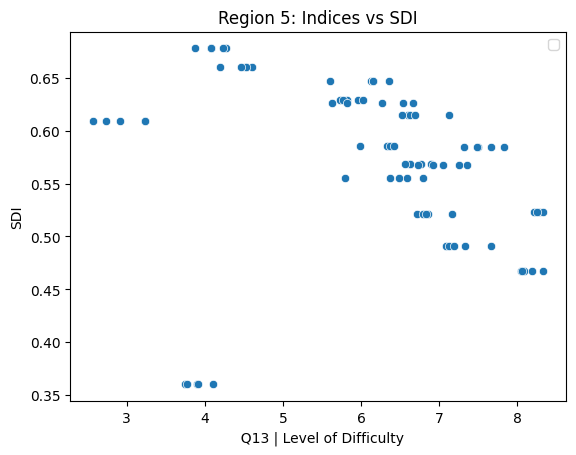

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


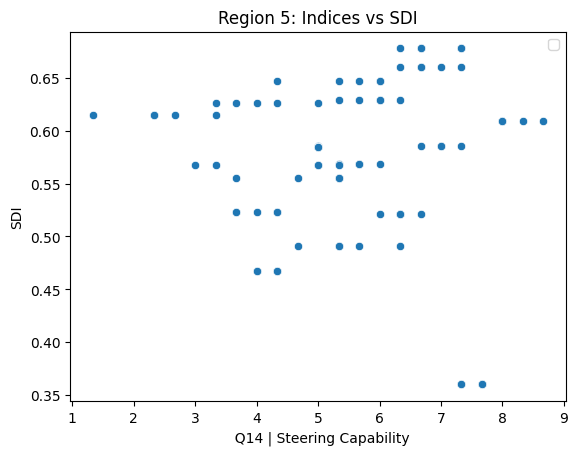

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


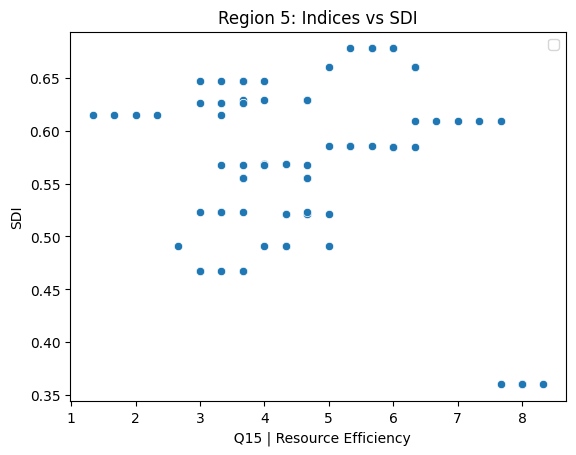

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


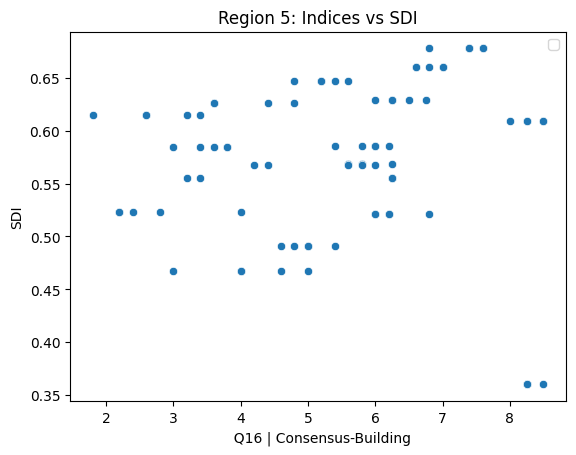

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


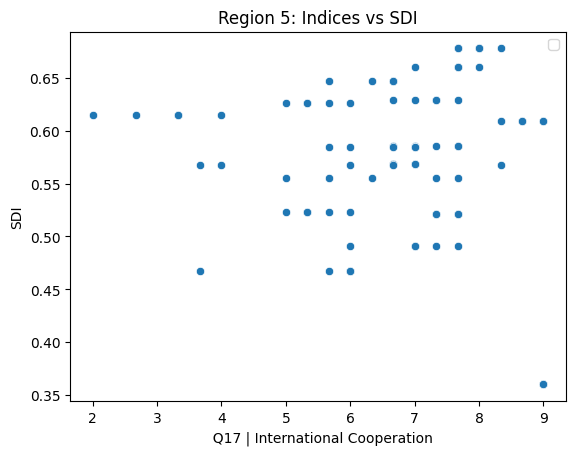

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


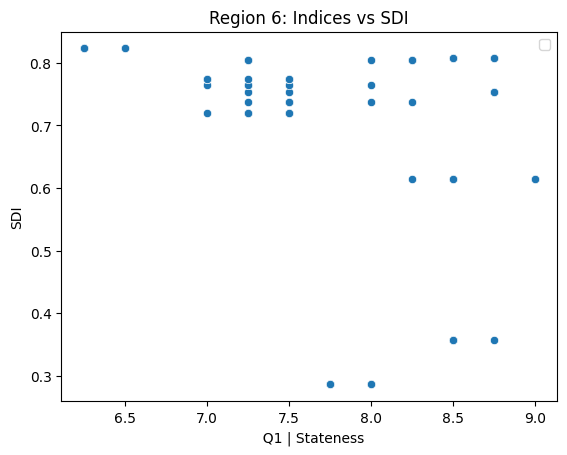

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


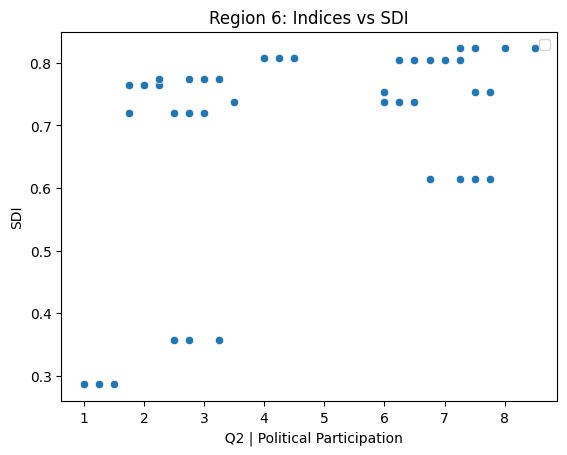

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


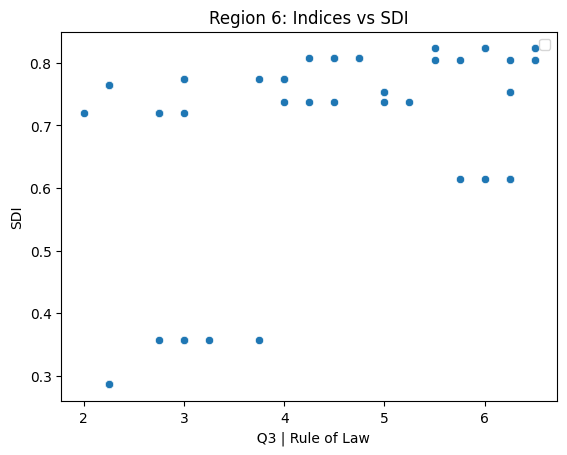

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


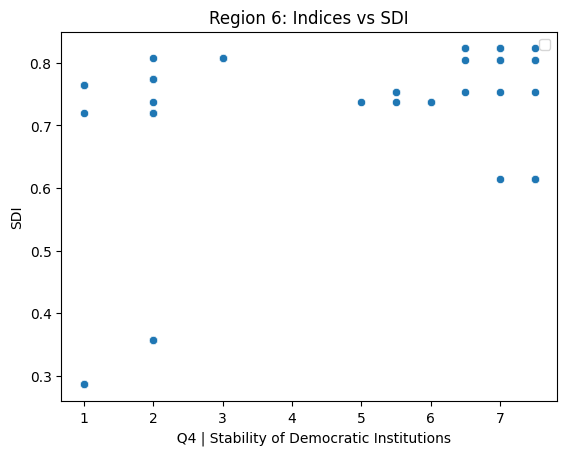

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


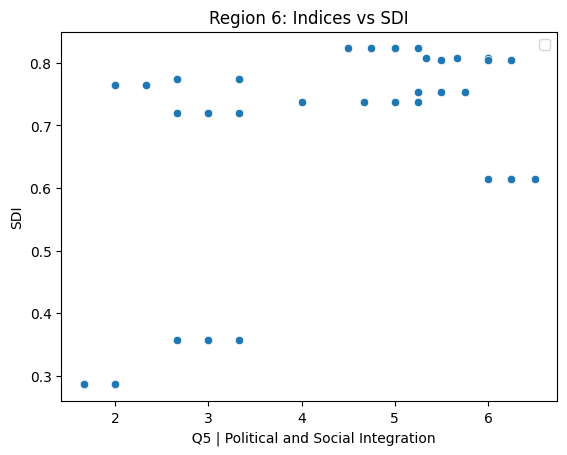

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


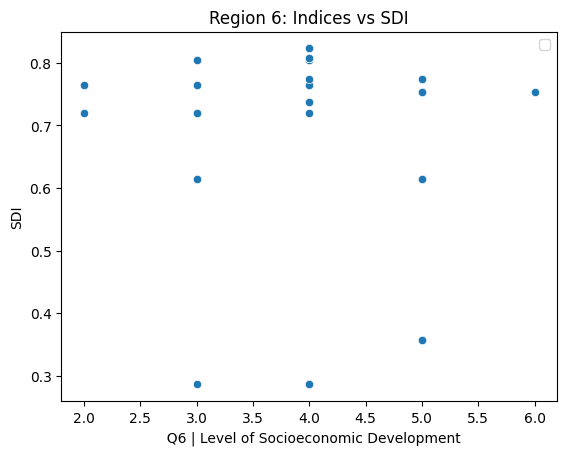

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


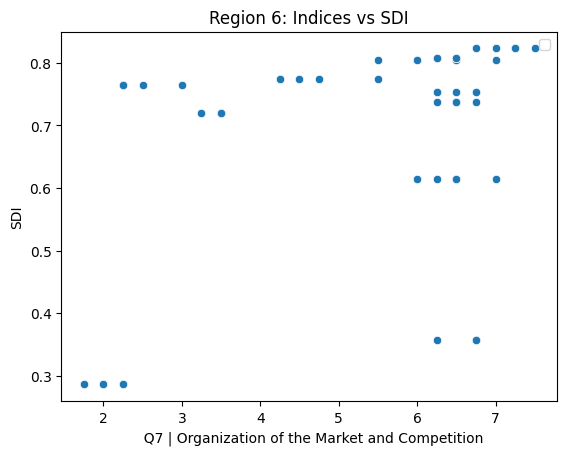

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


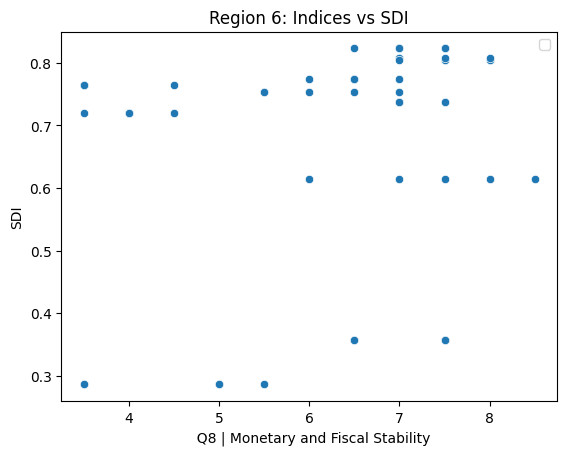

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


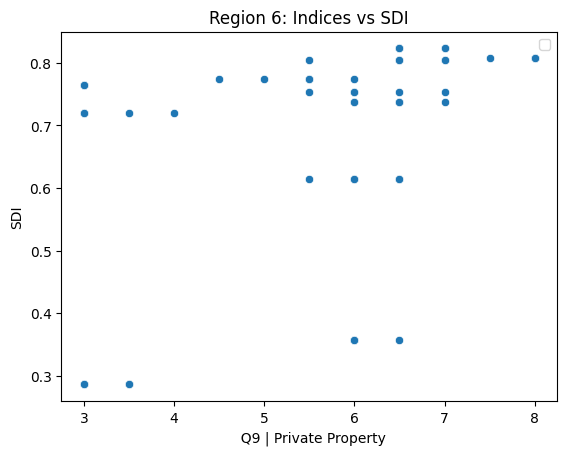

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


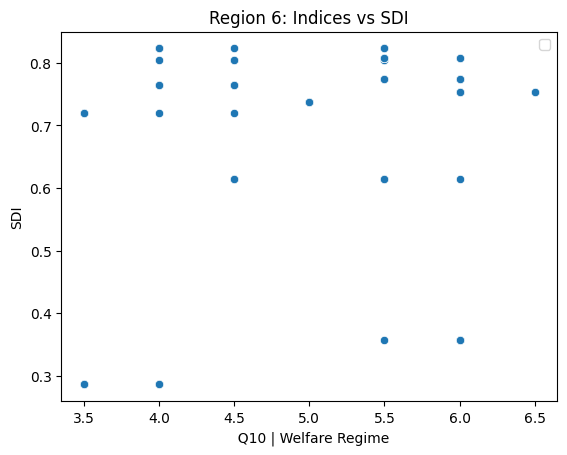

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


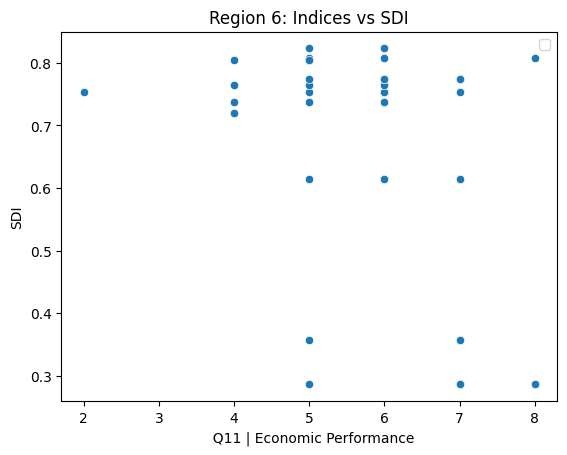

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


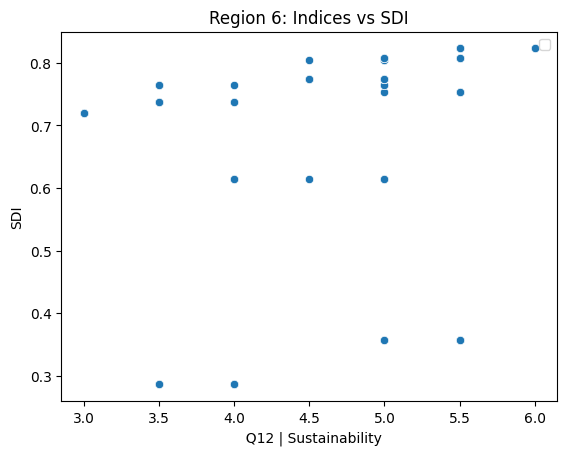

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


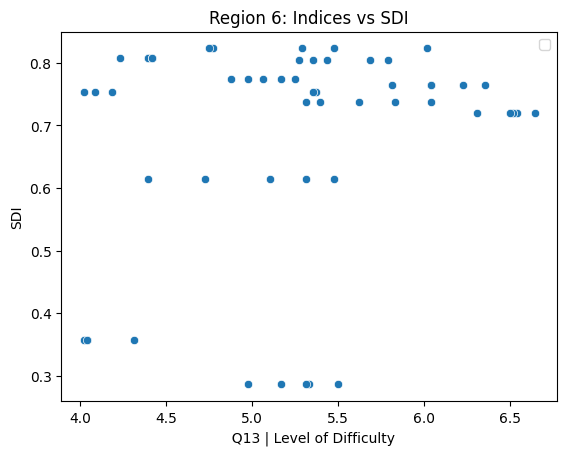

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


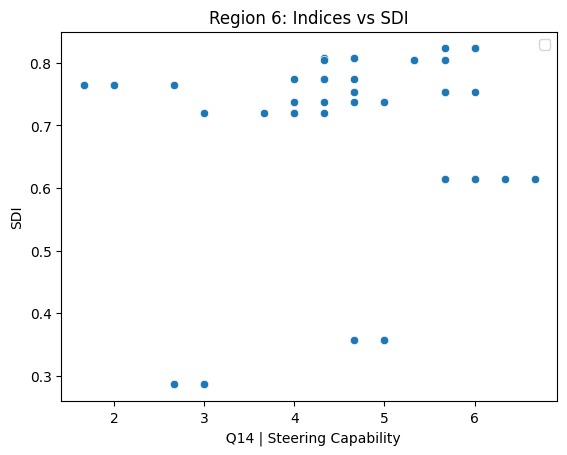

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


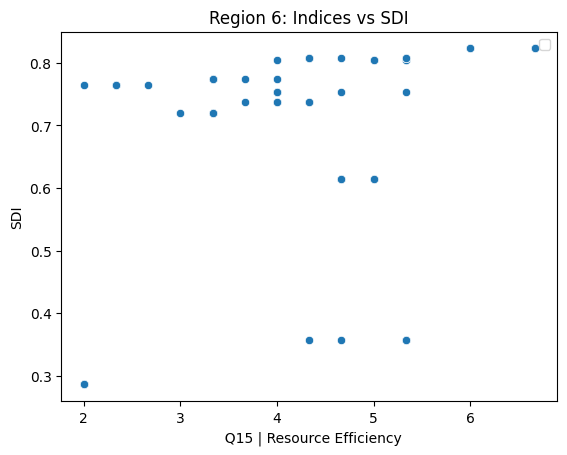

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


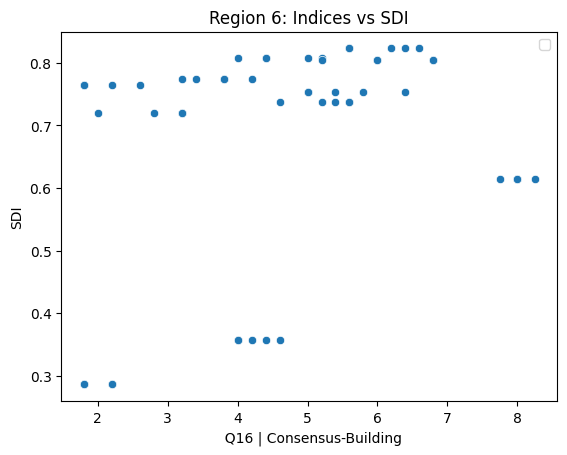

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


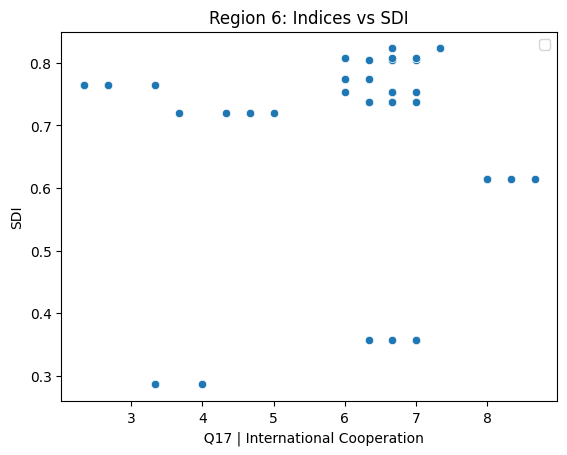

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


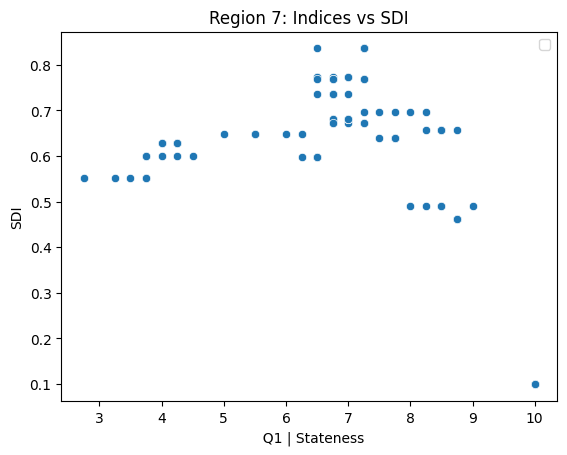

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


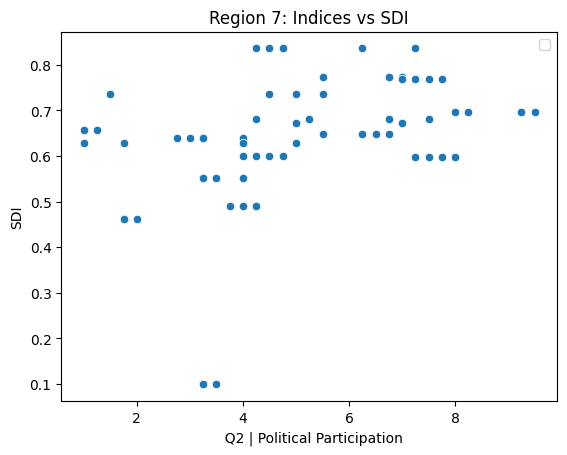

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


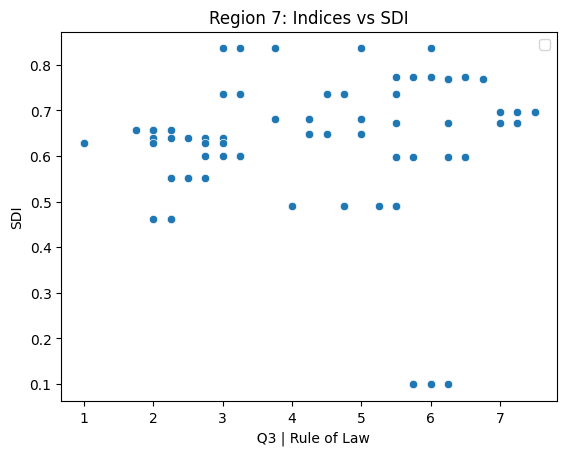

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


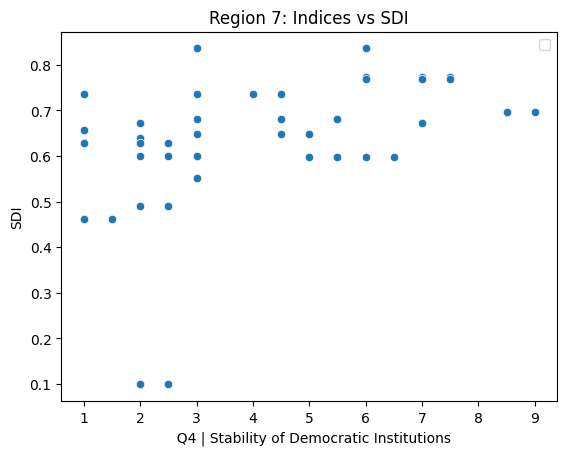

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


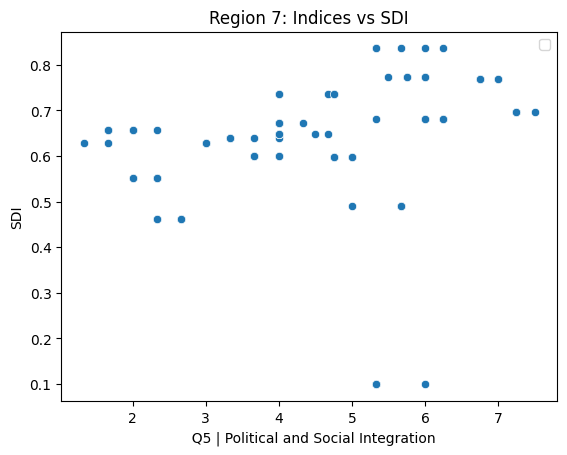

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


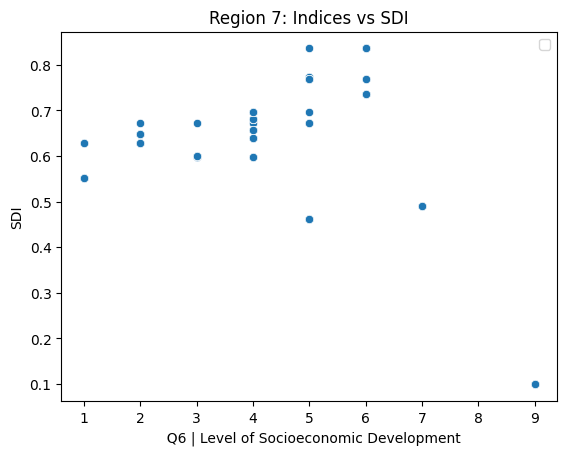

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


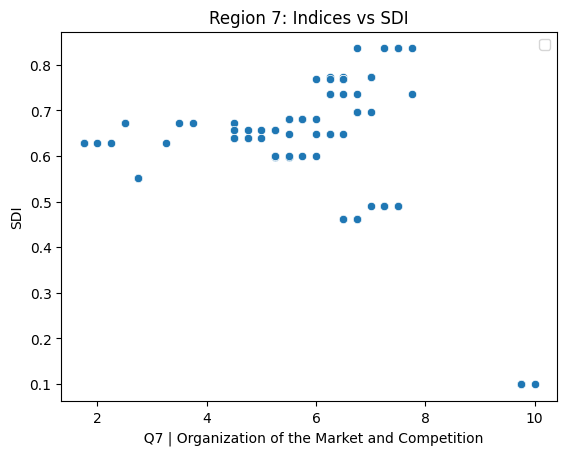

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


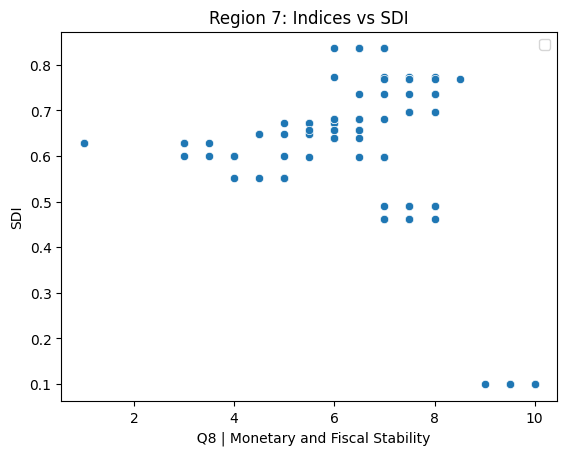

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


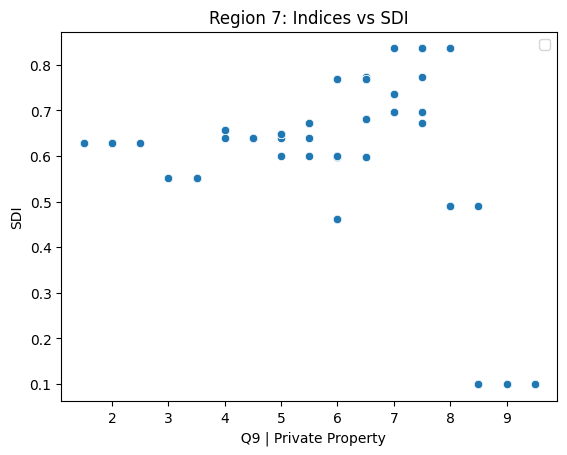

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


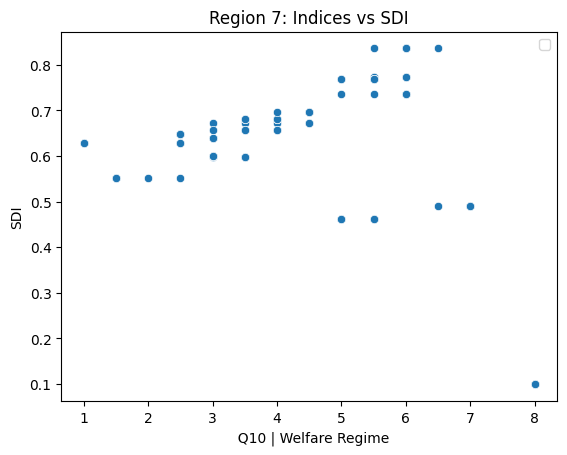

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


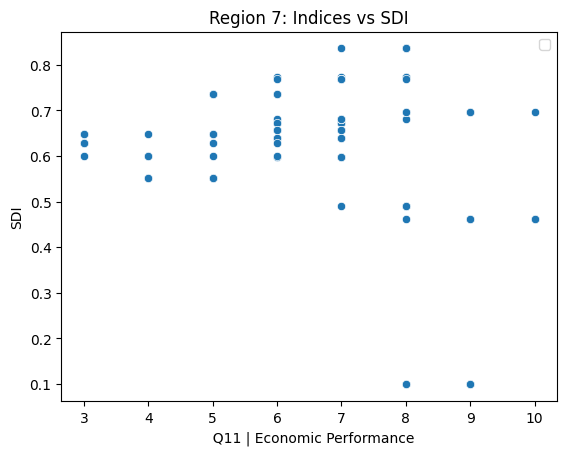

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


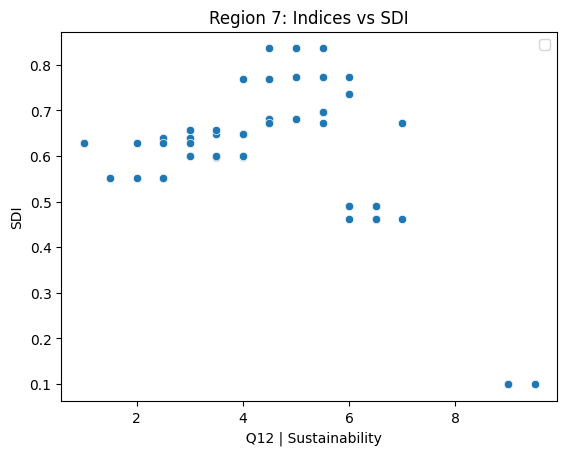

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


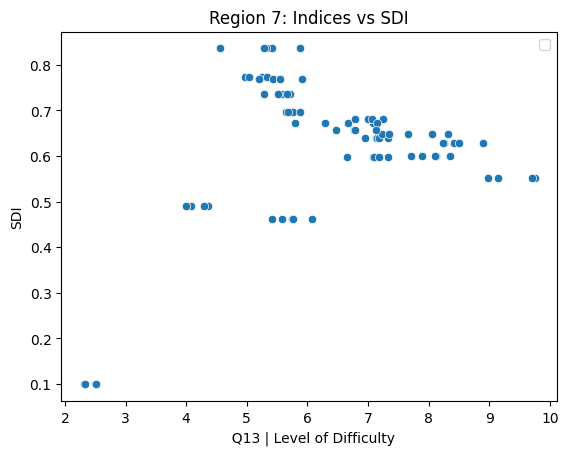

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


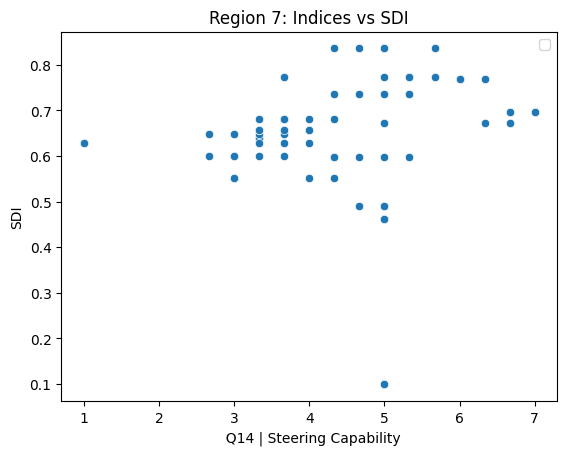

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


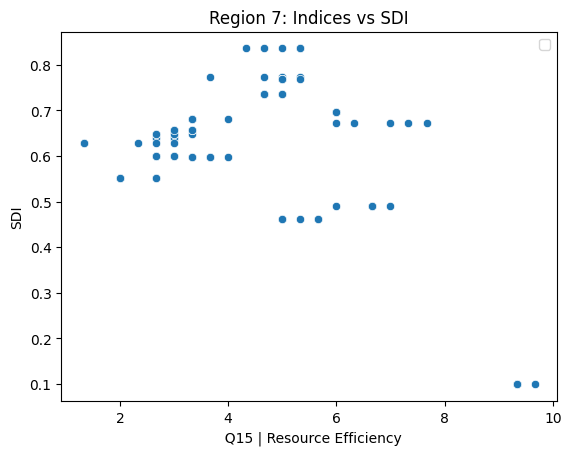

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


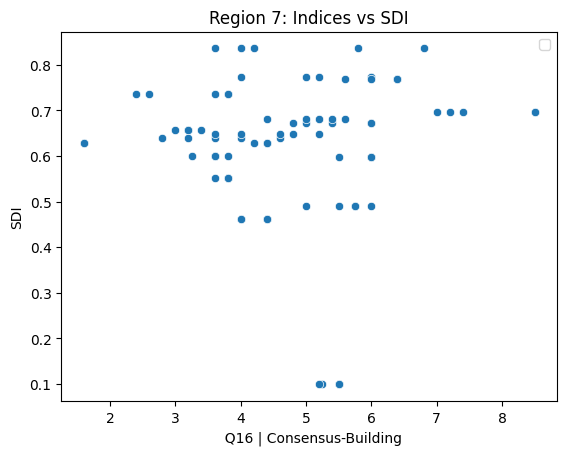

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


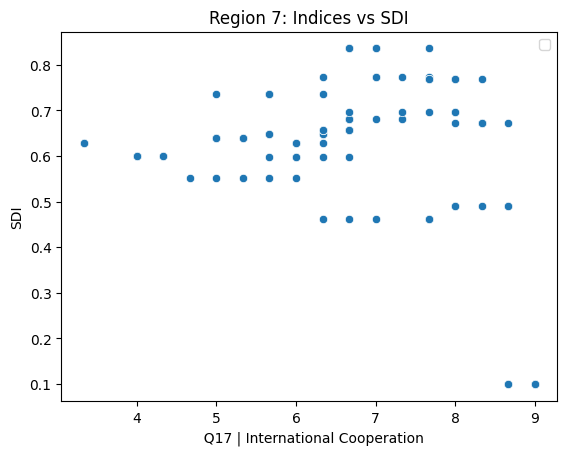

In [28]:
regions = [1, 2, 3, 4, 5, 6, 7]
important_indices_array = [col for col in important_indices.columns if col not in ['SDI', 'Region', 'Year', 'Country']]

# Create plots separated by region
for region in regions:
    #plt.figure(figsize=(10, 8))  # Adjust the size as needed
    group_country = important_indices.loc[important_indices['Region'] == region]

    for index in important_indices_array:
        sns.scatterplot(x=group_country[index], y=group_country['SDI'])

        plt.title(f'Region {region}: Indices vs SDI')
        plt.xlabel(index)
        plt.ylabel('SDI')
        plt.legend()
        plt.show()


## Heatmaps

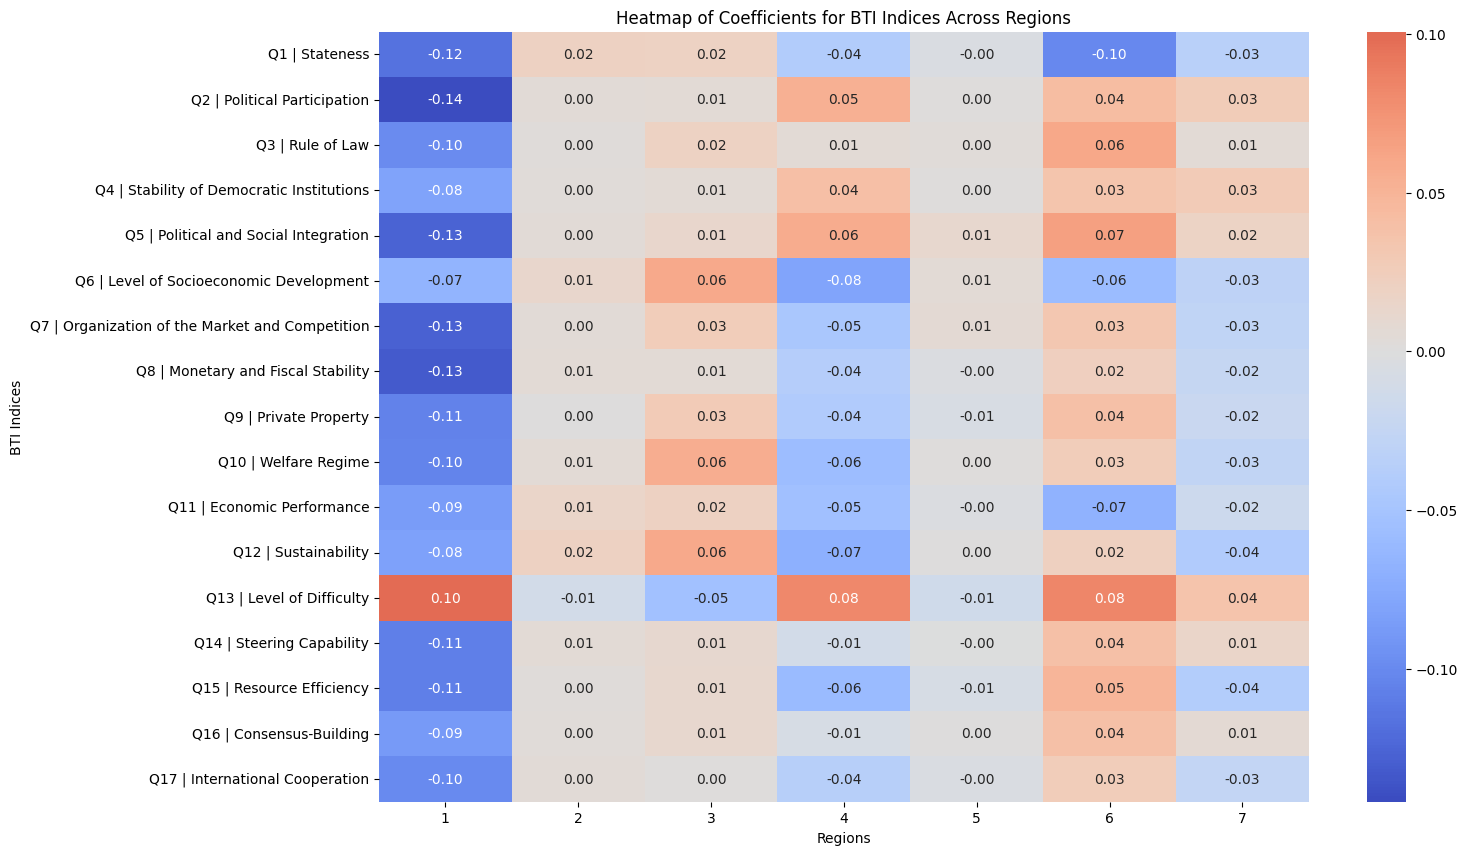

In [29]:
data_for_heatmap = {}


for region, indices in BTI_SDI_all_year_lin_corr.items():
    for index, metrics in indices.items():
        index_name = index.strip()
        coef_value = metrics['COEF'][0]
        data_for_heatmap.setdefault(index_name, {})[region] = coef_value

df_heatmap = pd.DataFrame(data_for_heatmap)


df_heatmap = df_heatmap.T


plt.figure(figsize=(15, 10))
sns.heatmap(df_heatmap, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Heatmap of Coefficients for BTI Indices Across Regions')
plt.xlabel('Regions')
plt.ylabel('BTI Indices')
#plt.gca().set_facecolor(my_custom_color)
#plt.gca().figure.patch.set_facecolor(my_custom_color)
plt.show()



# Now we are conducting multiple regression

## First, merge the dataframes to create one with all features----region, PCSDI and BTI q1-17.

In [58]:
important_indices

Year         Country  Region    SDI    Q1 | Stateness   
459  2010         Romania       1  0.692              9.25  \
145  2018  Czech Republic       1  0.399             10.00   
146  2016  Czech Republic       1  0.399             10.00   
147  2014  Czech Republic       1  0.399             10.00   
148  2012  Czech Republic       1  0.399             10.00   
..    ...             ...     ...    ...               ...   
244  2010       Indonesia       7  0.768              6.75   
285  2018            Laos       7  0.658              8.25   
286  2016            Laos       7  0.658              8.50   
238  2012           India       7  0.696              8.25   
0    2018     Afghanistan       7  0.551              3.75   

       Q2 | Political Participation    Q3 | Rule of Law   
459                            9.25                8.25  \
145                           10.00                9.25   
146                            9.75                9.25   
147                           10.00                9.25   
148                           10.00                9.25   
..                              ...                 ...   
244                            7.75                6.75   
285                            1.00                2.00   
286                            1.00                2.00   
238                            9.50                7.50   
0                              3.50                2.50   

       Q4 | Stability of Democratic Institutions   
459                                          8.5  \
145                                          9.0   
146                                          9.5   
147                                         10.0   
148                                         10.0   
..                                           ...   
244                                          7.0   
285                                          1.0   
286                                          1.0   
238                                          8.5   
0                                            3.0   

       Q5 | Political and Social Integration   
459                                 7.250000  \
145                                 8.750000   
146                                 8.750000   
147                                 8.750000   
148                                 9.000000   
..                                       ...   
244                                 6.750000   
285                                 2.333333   
286                                 2.000000   
238                                 7.250000   
0                                   2.333333   

       Q6 | Level of Socioeconomic Development  ...   
459                                        7.0  ...  \
145                                       10.0  ...   
146                                       10.0  ...   
147                                       10.0  ...   
148                                       10.0  ...   
..                                         ...  ...   
244                                        6.0  ...   
285                                        4.0  ...   
286                                        4.0  ...   
238                                        4.0  ...   
0                                          1.0  ...   

       Q8 | Monetary and Fiscal Stability    Q9 | Private Property   
459                                   9.0                      9.0  \
145                                  10.0                     10.0   
146                                   9.5                     10.0   
147                                   9.5                     10.0   
148                                   9.5                     10.0   
..                                    ...                      ...   
244                                   7.0                      6.0   
285                                   6.5                      4.0   
286                                   6.0                 

## Scaling

In [59]:
all_predictors_array = important_indices.columns
all_predictors = pd.merge(important_indices, PCSDI_2019, left_on = 'Country', right_on = 'COUNTRIES').drop(['COUNTRIES'], axis = 1)
all_predictors_2018 = all_predictors[all_predictors['Year'] == 2018]

from sklearn.preprocessing import MinMaxScaler
mm_scaler = MinMaxScaler(feature_range=(0, 1))
all_predictors_2018.iloc[:, 3:] = mm_scaler.fit_transform(all_predictors_2018.iloc[:, 3:])

In [60]:
all_predictors_2018_encoded = pd.get_dummies(all_predictors_2018, columns=['Region'])
all_predictors_2018_encoded
columns_to_convert = all_predictors_2018_encoded.iloc[:, -6:].columns
all_predictors_2018_encoded[columns_to_convert] = all_predictors_2018_encoded[columns_to_convert].astype(int)
all_predictors_2018_encoded

Year                 Country       SDI    Q1 | Stateness   
4    2018                 Romania  0.789614           0.93750  \
9    2018                Bulgaria  0.754993           0.93750   
10   2018                  Poland  0.427430           0.93750   
19   2018  Bosnia and Herzegovina  0.816245           0.62500   
24   2018                  Serbia  0.520639           0.87500   
..    ...                     ...       ...               ...   
500  2018                 Myanmar  0.704394           0.25000   
509  2018                Thailand  0.848202           0.59375   
514  2018               Sri Lanka  0.981358           0.65625   
515  2018               Indonesia  0.890812           0.56250   
524  2018               Singapore  0.000000           1.00000   

       Q2 | Political Participation    Q3 | Rule of Law   
4                          0.823529             0.78125  \
9                          0.794118             0.71875   
10                         0.911765             0.75000   
19                         0.647059             0.56250   
24                         0.794118             0.59375   
..                              ...                 ...   
500                        0.411765             0.12500   
509                        0.000000             0.12500   
514                        0.676471             0.50000   
515                        0.647059             0.53125   
524                        0.235294             0.46875   

       Q4 | Stability of Democratic Institutions   
4                                       0.722222  \
9                                       0.777778   
10                                      0.777778   
19                                      0.333333   
24                                      0.722222   
..                                           ...   
500                                     0.166667   
509                                     0.000000   
514                                     0.555556   
515                                     0.555556   
524                                     0.166667   

       Q5 | Political and Social Integration   
4                                   0.645161  \
9                                   0.645161   
10                                  0.774194   
19                                  0.516129   
24                                  0.645161   
..                                       ...   
500                                 0.129032   
509                                 0.258065   
514                                 0.548387   
515                                 0.612903   
524                                 0.430108   

       Q6 | Level of Socioeconomic Development   
4                                     0.666667  \
9                                     0.666667   
10                                    0.777778   
19                                    0.555556   
24                                    0.555556   
..                                         ...   
500                                   0.111111   
509                                   0.555556   
514                                   0.555556   
515                                   0.444444   
524                                   0.888889   

       Q7 | Organization of the Market and Competition  ...   
4                                              0.84375  ...  \
9                                              0.81250  ...   
10                                             0.96875  ...   
19                                             0.71875  ...   
24                                             0.78125  ...   
..                                                 ...  ...   
500                                            0.15625  ...   
509                                            0.53125  ...   
514                                            0.59375  ...   
515                                            0.56250  ...   
524                

## Then, do the lasso regression on it

In [33]:
all_predictors_2018_encoded

Year                 Country       SDI    Q1 | Stateness   
4    2018                 Romania  0.789614           0.93750  \
9    2018                Bulgaria  0.754993           0.93750   
10   2018                  Poland  0.427430           0.93750   
19   2018  Bosnia and Herzegovina  0.816245           0.62500   
24   2018                  Serbia  0.520639           0.87500   
..    ...                     ...       ...               ...   
500  2018                 Myanmar  0.704394           0.25000   
509  2018                Thailand  0.848202           0.59375   
514  2018               Sri Lanka  0.981358           0.65625   
515  2018               Indonesia  0.890812           0.56250   
524  2018               Singapore  0.000000           1.00000   

       Q2 | Political Participation    Q3 | Rule of Law   
4                          0.823529             0.78125  \
9                          0.794118             0.71875   
10                         0.911765             0.75000   
19                         0.647059             0.56250   
24                         0.794118             0.59375   
..                              ...                 ...   
500                        0.411765             0.12500   
509                        0.000000             0.12500   
514                        0.676471             0.50000   
515                        0.647059             0.53125   
524                        0.235294             0.46875   

       Q4 | Stability of Democratic Institutions   
4                                       0.722222  \
9                                       0.777778   
10                                      0.777778   
19                                      0.333333   
24                                      0.722222   
..                                           ...   
500                                     0.166667   
509                                     0.000000   
514                                     0.555556   
515                                     0.555556   
524                                     0.166667   

       Q5 | Political and Social Integration   
4                                   0.645161  \
9                                   0.645161   
10                                  0.774194   
19                                  0.516129   
24                                  0.645161   
..                                       ...   
500                                 0.129032   
509                                 0.258065   
514                                 0.548387   
515                                 0.612903   
524                                 0.430108   

       Q6 | Level of Socioeconomic Development   
4                                     0.666667  \
9                                     0.666667   
10                                    0.777778   
19                                    0.555556   
24                                    0.555556   
..                                         ...   
500                                   0.111111   
509                                   0.555556   
514                                   0.555556   
515                                   0.444444   
524                                   0.888889   

       Q7 | Organization of the Market and Competition  ...   
4                                              0.84375  ...  \
9                                              0.81250  ...   
10                                             0.96875  ...   
19                                             0.71875  ...   
24                                             0.78125  ...   
..                                                 ...  ...   
500                                            0.15625  ...   
509                                            0.53125  ...   
514                                            0.59375  ...   
515                                            0.56250  ...   
524                

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming X and y are your features and target variable
X_train, X_test, y_train, y_test = train_test_split(all_predictors_2018_encoded.iloc[:, 3:], all_predictors_2018_encoded['SDI'], test_size=0.2, random_state=42)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
from sklearn.linear_model import RidgeCV, LassoCV
alphas = np.logspace(-3 -2, 100)
# Lasso with cross-validation
lasso_cv = LassoCV(alphas= alphas, cv=5).fit(X_train_scaled, y_train)

# Ridge with cross-validation
ridge_cv = RidgeCV(alphas= alphas, cv=5).fit(X_train_scaled, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0251172792734502, tolerance: 0.0003274103065393634
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.02452651415804774, tolerance: 0.0003487411621240114
  model = cd_fast.enet_coordinate_descent_gram(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.013405711436818235, tolerance: 0.0002979987465355136
  model = cd_

In [36]:
#tuning parameters
best_alpha_lasso = lasso_cv.alpha_
best_alpha_ridge = ridge_cv.alpha_
lasso_coef = lasso_cv.coef_
ridge_coef = ridge_cv.coef_
# Making predictions
predictions_lasso = lasso_cv.predict(X_test_scaled)
predictions_ridge = ridge_cv.predict(X_test_scaled)



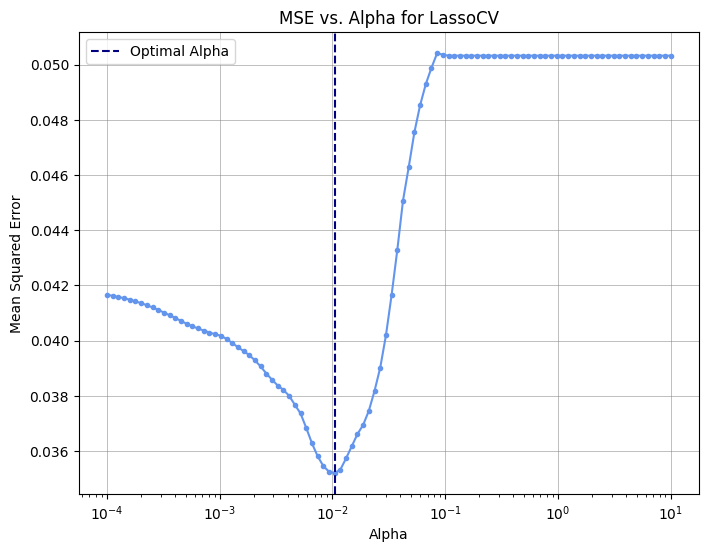

0.010476157527896652

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV


alphas = np.logspace(-4, 1, 100)

lasso_cv = LassoCV(alphas=alphas, cv=5, random_state=42).fit(X_train_scaled, y_train)

mse_path = lasso_cv.mse_path_.mean(axis=1)  # Mean MSE for each alpha
plt.figure(figsize=(8, 6))
fig = plt.plot(lasso_cv.alphas_, mse_path, marker='o', markersize = 3, color = 'cornflowerblue')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs. Alpha for LassoCV')
plt.axvline(lasso_cv.alpha_, color='navy', linestyle='--', label='Optimal Alpha')
plt.legend()
plt.grid(True, color='grey', linestyle='-', linewidth=0.5, alpha=0.7)
#plt.gca().set_facecolor(my_custom_color)
#plt.gca().figure.patch.set_facecolor(my_custom_color)
plt.show()
lasso_cv.alpha_


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.636e-02, tolerance: 4.001e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.636e-02, tolerance: 4.001e-04
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iter

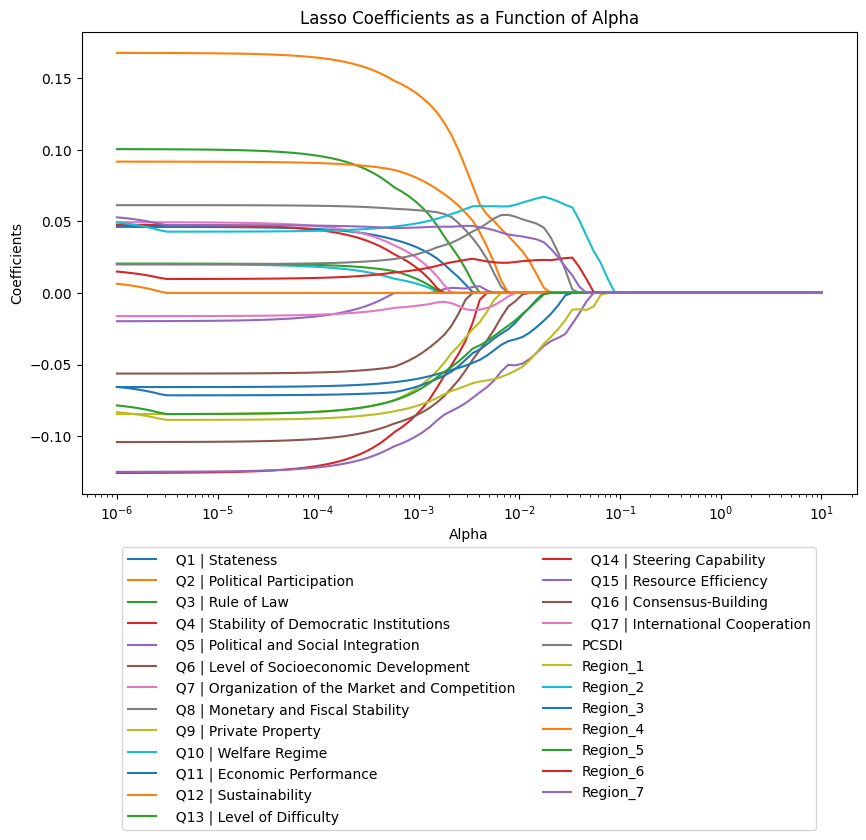

In [38]:
import numpy as np
feature_names = all_predictors_2018_encoded.iloc[:, 3:].columns

# Creating a logarithmically spaced range of alphas
alphas = np.logspace(-6, 1, 100)
from sklearn.linear_model import Lasso


coefs = []

for a in alphas:
    lasso = Lasso(alpha=a, fit_intercept=True, max_iter=10000)
    lasso.fit(X_train_scaled, y_train)
    coefs.append(lasso.coef_)
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
for coef, feature in zip(np.array(coefs).T, feature_names):
    plt.plot(alphas, coef, label=feature)

plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso Coefficients as a Function of Alpha')
plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0.5, -0.1))  # Adjust legend positioning as needed
plt.axis('tight')
plt.show()


In [39]:
chosen_alpha = best_alpha_lasso

lasso_model = Lasso(alpha=chosen_alpha)
lasso_model.fit(X_train_scaled, y_train)

non_zero_coefficients = np.sum(lasso_model.coef_ != 0)
print("Number of features used:", {non_zero_coefficients})
print("Chosen_alpha:", best_alpha_lasso)

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

predictions = lasso_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print("MSE on Test Set:", mse)
print("MAE on Test Set:", mae)

feature_coef_dict = dict(zip(feature_names, lasso_model.coef_))

# Create a DataFrame from the dictionary with feature names as the index
df_feature_coef = pd.DataFrame(list(feature_coef_dict.values()), index=feature_coef_dict.keys(), columns=['Coefficient'])

# Show the DataFrame
df_feature_coef
non_zero_coef_df = df_feature_coef[df_feature_coef['Coefficient']!=0]
non_zero_coef_df


Number of features used: {23}
Chosen_alpha: 0.0013894954943731374
MSE on Test Set: 0.05220107424655327
MAE on Test Set: 0.18675715855258904


Coefficient
  Q1 | Stateness                                      0.025852
  Q2 | Political Participation                        0.129212
  Q3 | Rule of Law                                    0.051119
  Q4 | Stability of Democratic Institutions          -0.070629
  Q6 | Level of Socioeconomic Development            -0.078559
  Q7 | Organization of the Market and Competition     0.014646
  Q8 | Monetary and Fiscal Stability                  0.056694
  Q9 | Private Property                              -0.057181
  Q10 | Welfare Regime                                0.002427
  Q11 | Economic Performance                         -0.057474
  Q12 | Sustainability                                0.074118
  Q13 | Level of Difficulty                           0.003669
  Q14 | Steering Capability                           0.006754
  Q15 | Resource Efficiency                          -0.091681
  Q16 | Consensus-Building                           -0.035998
  Q17 | International Cooperation                    -0.007291
PCSDI                                                 0.030757
Region_1                                             -0.074634
Region_2                                              0.051040
Region_3                                             -0.061102
Region_5                                             -0.061042
Region_6                                              0.018223
Region_7                                              0.046207

In [40]:
important_indices

Year         Country  Region    SDI    Q1 | Stateness   
459  2010         Romania       1  0.692              9.25  \
145  2018  Czech Republic       1  0.399             10.00   
146  2016  Czech Republic       1  0.399             10.00   
147  2014  Czech Republic       1  0.399             10.00   
148  2012  Czech Republic       1  0.399             10.00   
..    ...             ...     ...    ...               ...   
244  2010       Indonesia       7  0.768              6.75   
285  2018            Laos       7  0.658              8.25   
286  2016            Laos       7  0.658              8.50   
238  2012           India       7  0.696              8.25   
0    2018     Afghanistan       7  0.551              3.75   

       Q2 | Political Participation    Q3 | Rule of Law   
459                            9.25                8.25  \
145                           10.00                9.25   
146                            9.75                9.25   
147                           10.00                9.25   
148                           10.00                9.25   
..                              ...                 ...   
244                            7.75                6.75   
285                            1.00                2.00   
286                            1.00                2.00   
238                            9.50                7.50   
0                              3.50                2.50   

       Q4 | Stability of Democratic Institutions   
459                                          8.5  \
145                                          9.0   
146                                          9.5   
147                                         10.0   
148                                         10.0   
..                                           ...   
244                                          7.0   
285                                          1.0   
286                                          1.0   
238                                          8.5   
0                                            3.0   

       Q5 | Political and Social Integration   
459                                 7.250000  \
145                                 8.750000   
146                                 8.750000   
147                                 8.750000   
148                                 9.000000   
..                                       ...   
244                                 6.750000   
285                                 2.333333   
286                                 2.000000   
238                                 7.250000   
0                                   2.333333   

       Q6 | Level of Socioeconomic Development  ...   
459                                        7.0  ...  \
145                                       10.0  ...   
146                                       10.0  ...   
147                                       10.0  ...   
148                                       10.0  ...   
..                                         ...  ...   
244                                        6.0  ...   
285                                        4.0  ...   
286                                        4.0  ...   
238                                        4.0  ...   
0                                          1.0  ...   

       Q8 | Monetary and Fiscal Stability    Q9 | Private Property   
459                                   9.0                      9.0  \
145                                  10.0                     10.0   
146                                   9.5                     10.0   
147                                   9.5                     10.0   
148                                   9.5                     10.0   
..                                    ...                      ...   
244                                   7.0                      6.0   
285                                   6.5                      4.0   
286                                   6.0                 

# #  Multiple regression with major indices

In [61]:
BTI_2018_major_indices = BTI_2018.iloc[:, [0, 1, 5, 30, 61]].rename(columns = {BTI_2018.columns[0]: 'Country'})

IndexError: positional indexers are out-of-bounds

In [65]:
BTI_2018

Regions:\n1 | East-Central and Southeast Europe\n2 | Latin America and the Caribbean\n3 | West and Central Africa\n4 | Middle East and North Africa\n5 | Southern and Eastern Africa\n6 | Post-Soviet Eurasia\n7 | Asia and Oceania   
0                                          Afghanistan                                                                                                                                                                                   \
1                                              Albania                                                                                                                                                                                    
2                                              Algeria                                                                                                                                                                                    
3                                               Angola                                                                                                                                                                                    
4                                            Argentina                                                                                                                                                                                    
..                                                 ...                                                                                                                                                                                    
132                                          Venezuela                                                                                                                                                                                    
133                                            Vietnam                                                                                                                                                                                    
134                                              Yemen                                                                                                                                                                                    
135                                             Zambia                                                                                                                                                                                    
136                                           Zimbabwe                                                                                                                                                                                    

       Region   Ranking Status Index   S | Status Index   
0           7                    121           2.954762  \
1           1                     30           6.828571   
2           4                     83           4.982143   
3           5                    105           3.939286   
4           2                     23           7.267857   
..        ...                    ...                ...   
132         2                    110           3.471429   
133         7                     94           4.407143   
134         4                    127           1.721429   
135         5                     67           5.446429   
136         5                    113           3.327381   

      Ranking Democracy Status   SI | Democracy Status   Q1 | Stateness   
0                          114                3.016667             3.75  \
1                           34                    7.05                9   
2                           79                    4.75              7.5   
3                           87                     4.2              7.5   
4                           19                       8                9   
..                      

In [66]:
#major_indices contains 2018 data
major_indices = pd.merge(BTI_2018_major_indices, SDI_2019, left_on = 'Country', right_on = 'Country').dropna()
major_indices = pd.merge(major_indices, PCSDI_2019, left_on = 'Country', right_on = 'COUNTRIES').rename(columns = {major_indices.columns[2]: 'SI', major_indices.columns[3]: 'SII', major_indices.columns[4]: 'GII'})
major_indices.head()
country = major_indices['Country']

In [67]:
major_indices = major_indices.apply(pd.to_numeric, errors='coerce')
major_indices['Country'] = country

major_indices = major_indices.dropna(axis=1, how='all')

major_indices = major_indices.dropna(axis=0, how='any')

scaler = MinMaxScaler(feature_range = (0, 1))
major_indices.iloc[:, 2:] = scaler.fit_transform(major_indices.iloc[:, 2:])
major_indices

Country    Region        SI       SII       GII       SDI     PCSDI
0       Albania         1  0.644172  0.649533  0.694570  0.941411  0.736880
1       Algeria         4  0.361963  0.467290  0.454751  0.908123  0.348166
2        Angola         5  0.294479  0.266355  0.303167  0.701731  0.118903
3     Argentina         2  0.760736  0.640187  0.726244  0.885486  0.951643
4       Armenia         6  0.406953  0.574766  0.420814  0.942743  0.655072
..          ...       ...       ...       ...       ...       ...       ...
102  Uzbekistan         6  0.167689  0.345794  0.144796  0.885486  0.654142
103   Venezuela         2  0.245399  0.196262  0.053733  0.794940  0.596245
104       Yemen         4  0.000000  0.000000  0.000000  0.541944  0.237715
105      Zambia         5  0.515337  0.425234  0.520362  0.705726  0.302641
106    Zimbabwe         5  0.249489  0.154206  0.110860  0.687084  0.289978

[105 rows x 7 columns]

# Do we have colleanearity?

In [44]:
X = major_indices[['SI', 'GII', 'PCSDI']]
y = major_indices['SDI']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"MSE: {mse}")
print("MAE:", mae)
print(f"R^2 Score: {r2}")
print(f"Coefs: {model.coef_}")
#use correlation matrix to see multicollearity
corr_matrix = X.corr()
print(corr_matrix)
#SI and GII has multicollearity. 

MSE: 0.035811076551321736
MAE: 0.14895266013577538
R^2 Score: 0.13841881990439375
Coefs: [ 0.68370642 -0.94204239  0.2688599 ]
             SI       GII     PCSDI
SI     1.000000  0.890136  0.614786
GII    0.890136  1.000000  0.522552
PCSDI  0.614786  0.522552  1.000000


Mean Squared Error: 0.03395056720361414
MAE: 0.14503614937624665
R^2 Score: 0.18318094363110016
Coefs: [-0.34860191  0.38706904]


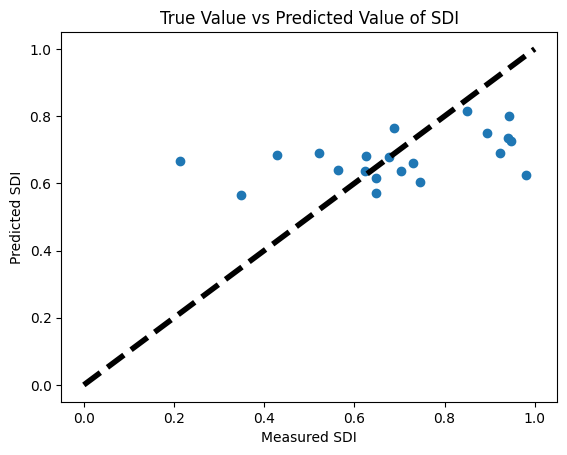

In [45]:
X = major_indices[['GII', 'PCSDI']] #remove one of SI and GII
y = major_indices['SDI'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


model = LinearRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print("MAE:", mae)
print(f"R^2 Score: {r2}")
print(f"Coefs: {model.coef_}")

# Visualization of the true vs predicted values of SDI
plt.scatter(y_test, y_pred)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
plt.xlabel('Measured SDI')
plt.ylabel('Predicted SDI')
plt.title('True Value vs Predicted Value of SDI')
plt.show()

In [46]:
#using statsmodel module for regression, GII alone
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                    SDI   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     7.700
Date:                Mon, 12 Aug 2024   Prob (F-statistic):           0.000868
Time:                        17:42:14   Log-Likelihood:                 12.355
No. Observations:                  84   AIC:                            -18.71
Df Residuals:                      81   BIC:                            -11.42
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6921      0.067     10.401      0.0

# how well is this model performing in other year's test set?

# Building model with tensorflow neural network

In [47]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Assuming df is your pandas DataFrame and has been read from the CSV or image file

# Prepare the data
X = major_indices[['SI', 'SII', 'GII']].values  # Features
y = major_indices['SDI'].values  # Target variable

# Split the data into training and testing sets (optional)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the neural network model
model = Sequential([
    Dense(64, input_dim=3, activation='relu'),  # Input layer with 3 features and 64 neurons
    Dense(32, activation='relu'),  # Hidden layer with 32 neurons
    Dense(1)  # Output layer with one neuron for regression output
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_absolute_error'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1)

# Evaluate the model (optional)
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test Mean Absolute Error: {mae}")

# Predict SDI (optional)
predictions = model.predict(X_test)


Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.6240 - mean_absolute_error: 0.7608 - val_loss: 0.4609 - val_mean_absolute_error: 0.6497
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5639 - mean_absolute_error: 0.7167 - val_loss: 0.3848 - val_mean_absolute_error: 0.5858
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4381 - mean_absolute_error: 0.6260 - val_loss: 0.3192 - val_mean_absolute_error: 0.5235
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3754 - mean_absolute_error: 0.5751 - val_loss: 0.2644 - val_mean_absolute_error: 0.4674
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2834 - mean_absolute_error: 0.4944 - val_loss: 0.2211 - val_mean_absolute_error: 0.4322
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2311 - mean_absolute_error: 0.4458 - val_loss: 0.1840 - val_mean_absolute_error: 0.3953
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1871 - mean_absolute_error: 0.3955 - val_loss: 0.1532 - val_mean_absol

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0475 - mean_absolute_error: 0.1721 - val_loss: 0.0798 - val_mean_absolute_error: 0.2238
Epoch 47/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0475 - mean_absolute_error: 0.1765 - val_loss: 0.0781 - val_mean_absolute_error: 0.2212
Epoch 48/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0422 - mean_absolute_error: 0.1636 - val_loss: 0.0767 - val_mean_absolute_error: 0.2192
Epoch 49/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0489 - mean_absolute_error: 0.1788 - val_loss: 0.0757 - val_mean_absolute_error: 0.2175
Epoch 50/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0541 - mean_absolute_error: 0.1895 - val_loss: 0.0743 - val_mean_absolute_error: 0.2152
Epoch 51/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0504 - mean_absolute_error: 0.1795 - val_loss: 0.0731 - val_mean_absolute_error: 0.2132
Epoch 52/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0442 - mean_absolute_error: 0.1691 - val_loss: 0.0722 - val_mean_

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0260 - mean_absolute_error: 0.1316 - val_loss: 0.0506 - val_mean_absolute_error: 0.1815
Epoch 92/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0293 - mean_absolute_error: 0.1398 - val_loss: 0.0508 - val_mean_absolute_error: 0.1796
Epoch 93/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0292 - mean_absolute_error: 0.1431 - val_loss: 0.0508 - val_mean_absolute_error: 0.1803
Epoch 94/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0294 - mean_absolute_error: 0.1404 - val_loss: 0.0510 - val_mean_absolute_error: 0.1819
Epoch 95/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - mean_absolute_error: 0.1331 - val_loss: 0.0513 - val_mean_absolute_error: 0.1846
Epoch 96/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0248 - mean_absolute_error: 0.1281 - val_loss: 0.0513 - val_mean_absolute_error: 0.1845
Epoch 97/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 - mean_absolute_error: 0.1295 - val_loss: 0.0512 - val_mean_

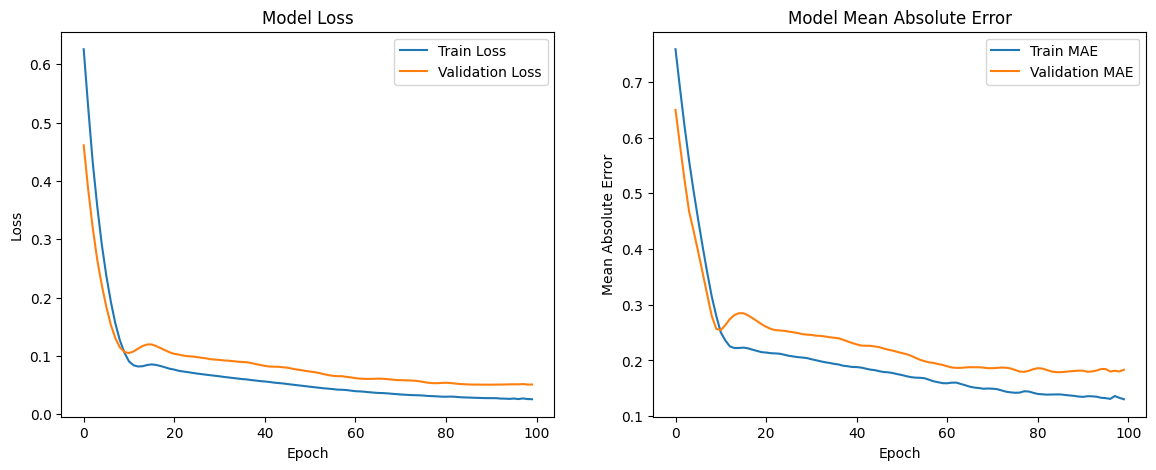

In [48]:
import matplotlib.pyplot as plt

# Assuming we've already trained the model with the code from the previous message
# and the variable 'history' contains the history of the training process

# Visualize the training process: Loss and Mean Absolute Error
plt.figure(figsize=(14, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plot Mean Absolute Error
plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Model Mean Absolute Error')
plt.ylabel('Mean Absolute Error')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()


# Explore possible relation of economic indicators and governance performance

In [49]:
major_indices

Country    Region        SI       SII       GII       SDI     PCSDI
0       Albania         1  0.644172  0.649533  0.694570  0.941411  0.736880
1       Algeria         4  0.361963  0.467290  0.454751  0.908123  0.348166
2        Angola         5  0.294479  0.266355  0.303167  0.701731  0.118903
3     Argentina         2  0.760736  0.640187  0.726244  0.885486  0.951643
4       Armenia         6  0.406953  0.574766  0.420814  0.942743  0.655072
..          ...       ...       ...       ...       ...       ...       ...
102  Uzbekistan         6  0.167689  0.345794  0.144796  0.885486  0.654142
103   Venezuela         2  0.245399  0.196262  0.053733  0.794940  0.596245
104       Yemen         4  0.000000  0.000000  0.000000  0.541944  0.237715
105      Zambia         5  0.515337  0.425234  0.520362  0.705726  0.302641
106    Zimbabwe         5  0.249489  0.154206  0.110860  0.687084  0.289978

[105 rows x 7 columns]

Text(0, 0.5, 'GDP growth')

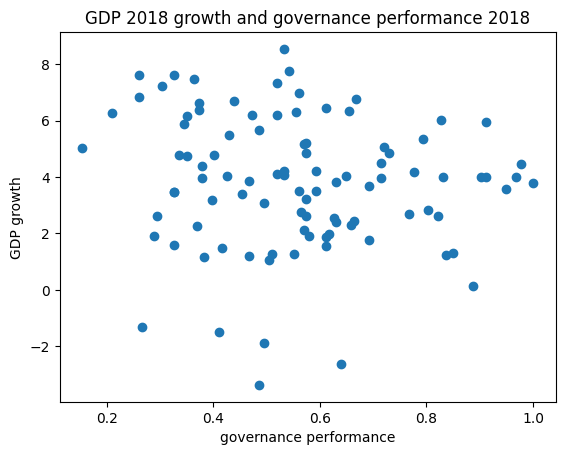

In [50]:
GDP_growth_all = pd.read_csv('/Users/noira/Desktop/GDP Growth all.csv')
GDP_growth_all.head(5)

GDP_growth_2018 = GDP_growth_all[['Country Name', '2018']]


major_indices_with_GDP = pd.merge(major_indices, GDP_growth_2018, left_on = 'Country', right_on = 'Country Name').dropna()
visualize = plt.scatter(x = major_indices_with_GDP['SII'], y = major_indices_with_GDP['2018'])
plt.show
plt.title('GDP 2018 growth and governance performance 2018')
plt.xlabel('governance performance')
plt.ylabel('GDP growth')

In [51]:
y = major_indices_with_GDP['SII']
X = major_indices_with_GDP[['2018']]
    
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
model.coef_

array([-0.01325338])

In [52]:
#what about all years?
SII_all_years = BTI_all_years.filter(regex='SII|Country|Year')
SII_GDP_all_years = pd.merge(SII_all_years, GDP_growth_2018, left_on = 'Country', right_on = 'Country Name')
SII_GDP_all_years

Country   SII | Economy Status   SII | Economy Status.1  Year   
0    Afghanistan               2.892857                     2.89  2018  \
1    Afghanistan               2.892857                     2.89  2016   
2    Afghanistan               2.964286                     2.96  2014   
3    Afghanistan               2.892857                     2.89  2012   
4    Afghanistan               2.821429                     2.82  2010   
..           ...                    ...                      ...   ...   
590     Zimbabwe               2.821429                     2.82  2018   
591     Zimbabwe               3.464286                     3.46  2016   
592     Zimbabwe               3.428571                     3.43  2014   
593     Zimbabwe               2.785714                     2.79  2012   
594     Zimbabwe               2.071429                     2.07  2010   

    Country Name      2018  
0    Afghanistan  1.189228  
1    Afghanistan  1.189228  
2    Afghanistan  1.189228  
3    Afghanistan  1.189228  
4    Afghanistan  1.189228  
..           ...       ...  
590     Zimbabwe  5.009867  
591     Zimbabwe  5.009867  
592     Zimbabwe  5.009867  
593     Zimbabwe  5.009867  
594     Zimbabwe  5.009867  

[595 rows x 6 columns]

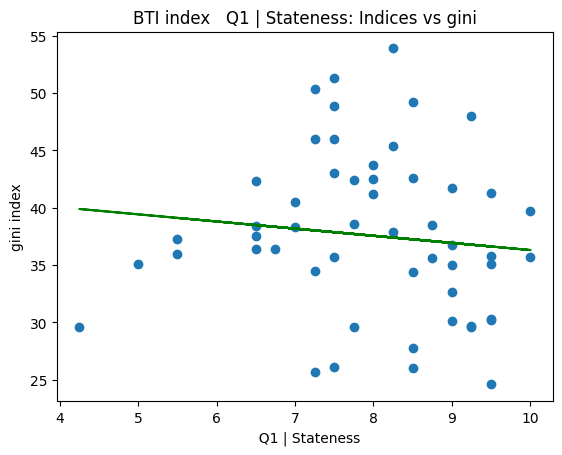

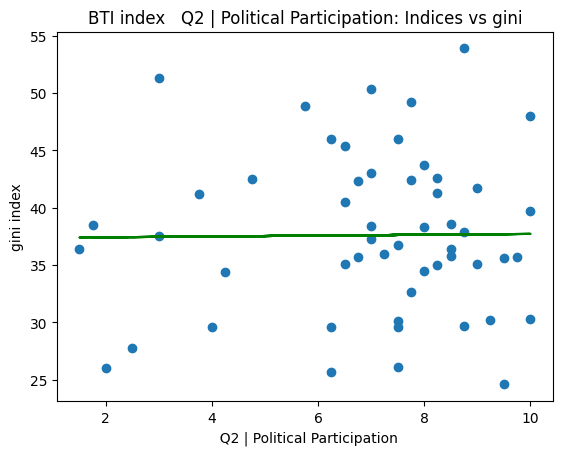

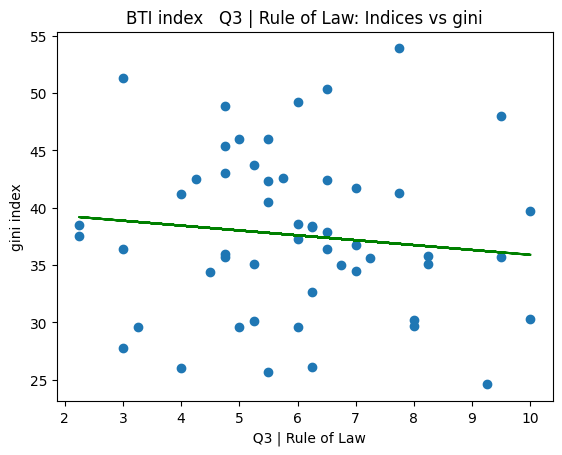

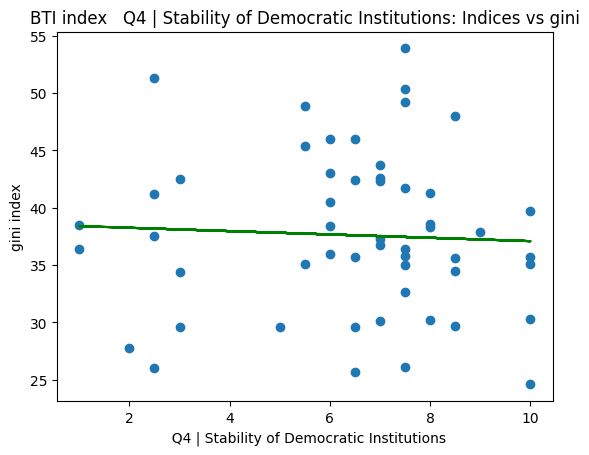

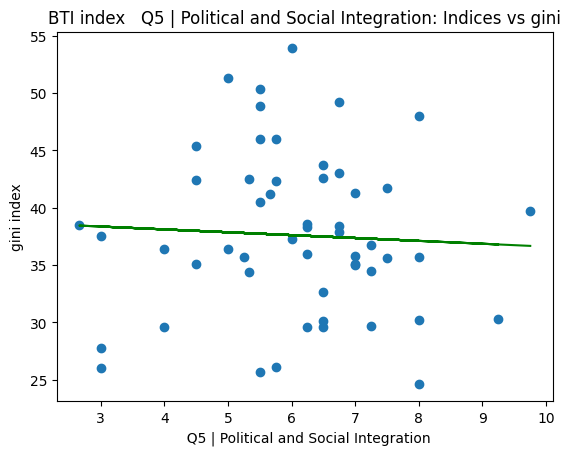

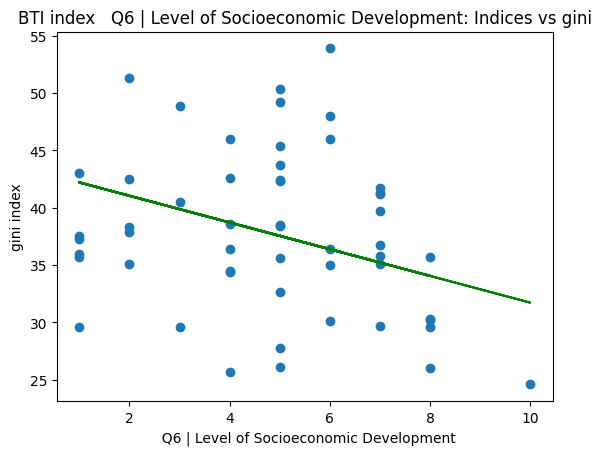

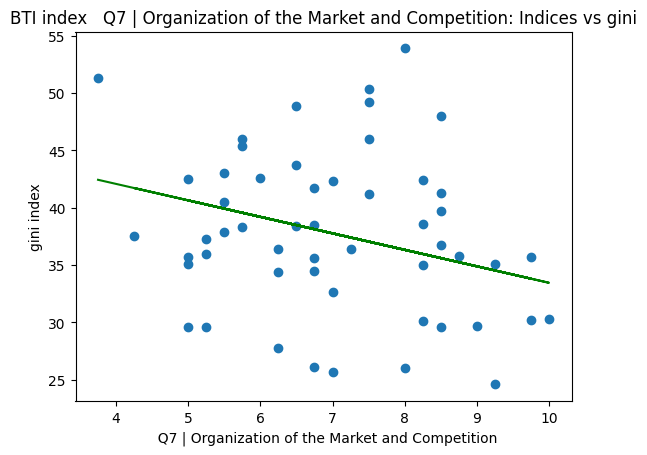

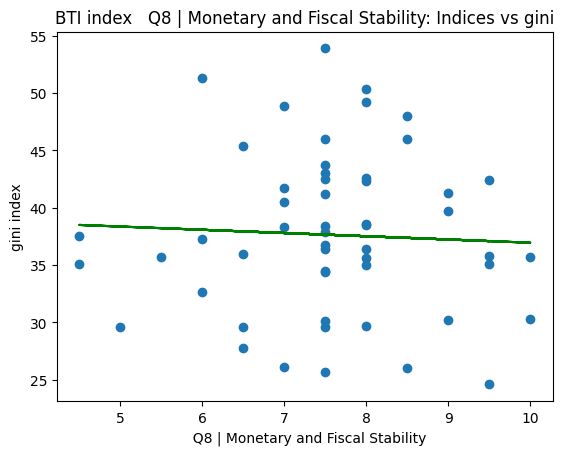

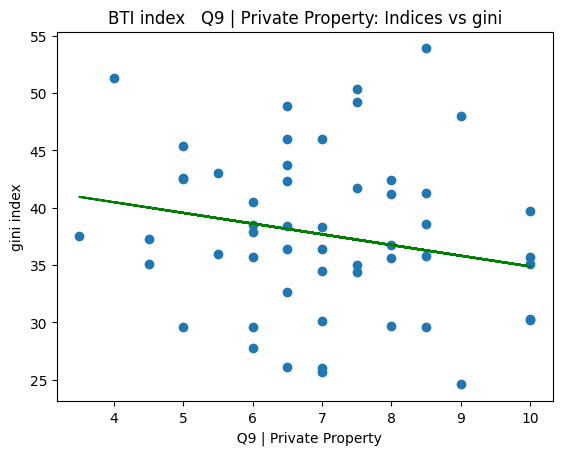

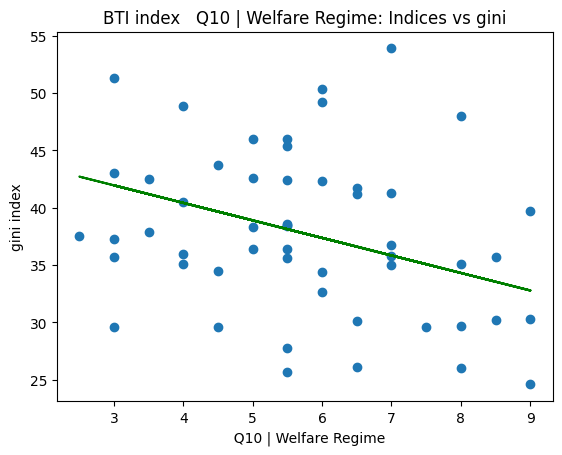

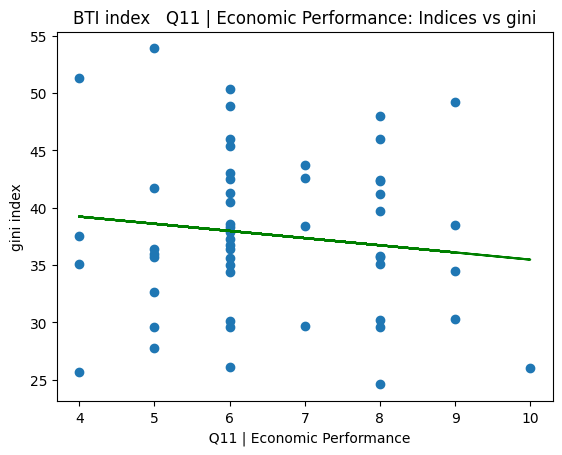

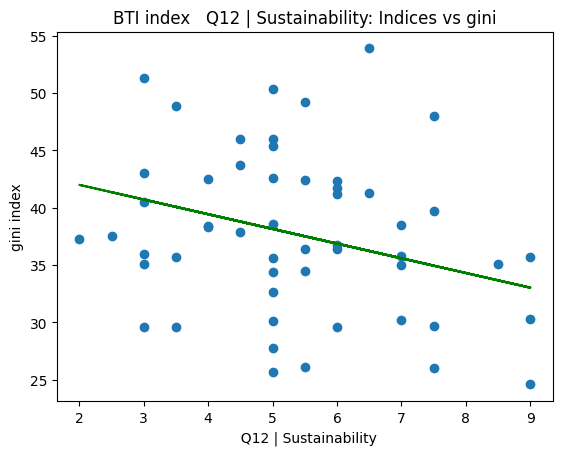

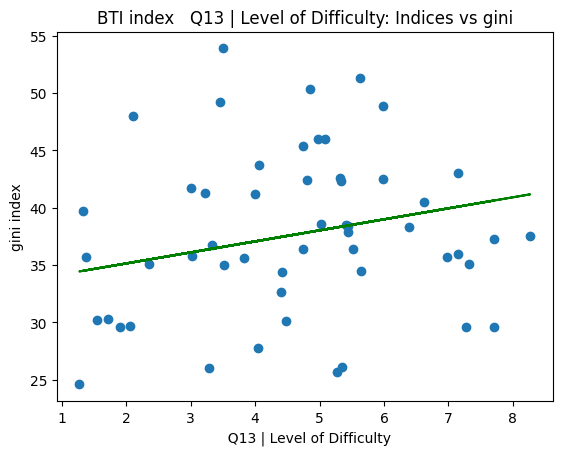

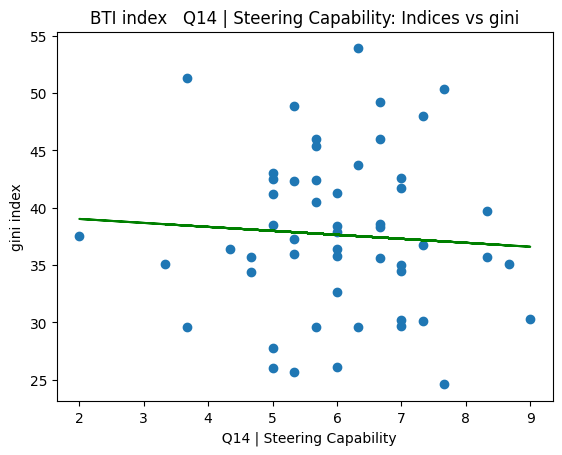

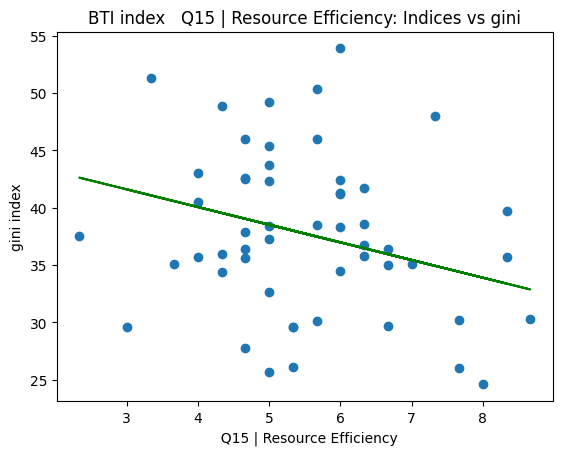

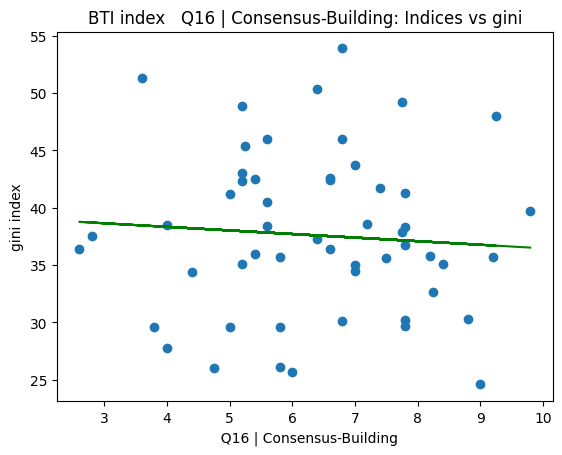

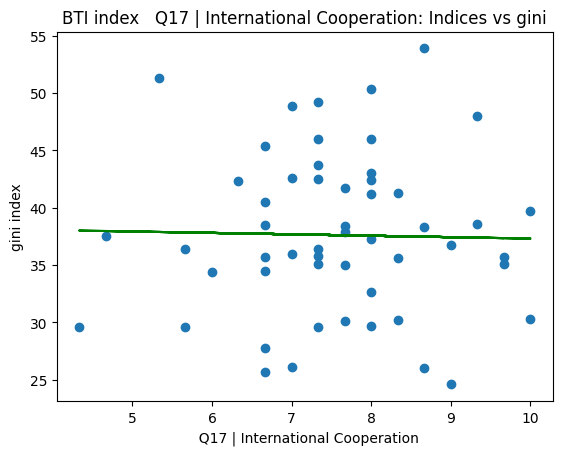

In [53]:
gini = pd.read_csv('/Users/noira/Desktop/gini.csv')
gini_2018 = gini[['Country Name', '2018']]
gini_2018 = gini_2018.dropna()
gini_2018
BTI_2018 = important_indices[important_indices['Year'] == 2018]
BTI_gini = pd.merge(gini_2018, BTI_2018, left_on = 'Country Name', right_on = 'Country')
PCSDI_gini = pd.merge(gini_2018, major_indices, left_on = 'Country Name', right_on = 'Country')
coef_BTI_gini_2018 = {}

for column in BTI_gini.columns[6:]:
    y = BTI_gini['2018']
    X = BTI_gini[[column]]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LinearRegression()
    model.fit(X_train, y_train)
    coef_BTI_gini_2018[column] = [model.coef_, model.score(X_test, y_test)]
    plt.scatter(x = BTI_gini[column], y = BTI_gini['2018'])
    plt.title(f'BTI index {column}: Indices vs gini')
    plt.xlabel(column)
    plt.ylabel('gini index')
    plt.plot(X, model.predict(X), color='green')
    plt.show()

In [54]:
coef_BTI_gini_2018

{'  Q1 | Stateness': [array([-0.62282529]), -0.05107857992666465],
 '  Q2 | Political Participation': [array([0.03679262]),
  -0.011339897373238594],
 '  Q3 | Rule of Law': [array([-0.42476772]), -0.09267142549724894],
 '  Q4 | Stability of Democratic Institutions': [array([-0.14558356]),
  -0.027682009115874928],
 '  Q5 | Political and Social Integration': [array([-0.25000095]),
  -0.045341642177632036],
 '  Q6 | Level of Socioeconomic Development': [array([-1.16466901]),
  -0.653402996279915],
 '  Q7 | Organization of the Market and Competition': [array([-1.43694238]),
  -0.30485236432762286],
 '  Q8 | Monetary and Fiscal Stability': [array([-0.2819076]),
  -0.04051786824017389],
 '  Q9 | Private Property': [array([-0.93377278]), -0.20320059216509523],
 '  Q10 | Welfare Regime': [array([-1.52758462]), -0.44558327584919954],
 '  Q11 | Economic Performance': [array([-0.625252]), -0.14005890612229677],
 '  Q12 | Sustainability': [array([-1.28097762]), -0.31143753189738854],
 '  Q13 | Le

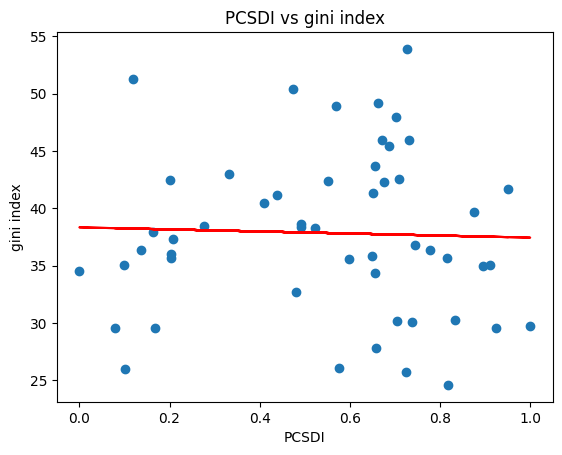

array([-0.89539963])

In [55]:
y = PCSDI_gini['2018']
X = PCSDI_gini[['PCSDI']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
plt.scatter(x = PCSDI_gini['PCSDI'], y = PCSDI_gini['2018'])
plt.title('PCSDI vs gini index')
plt.xlabel('PCSDI')
plt.ylabel('gini index')
plt.plot(X, model.predict(X), color='red')

plt.show()

model.coef_

                            OLS Regression Results                            
Dep. Variable:                    GII   R-squared:                       0.210
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     19.69
Date:                Mon, 12 Aug 2024   Prob (F-statistic):           3.11e-05
Time:                        17:42:32   Log-Likelihood:                 13.520
No. Observations:                  76   AIC:                            -23.04
Df Residuals:                      74   BIC:                            -18.38
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3251      0.051      6.363      0.0

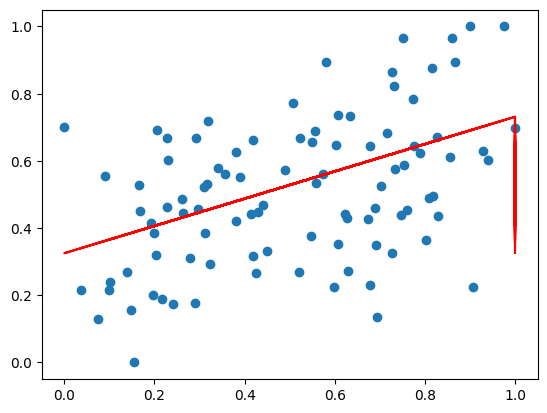

In [56]:
#globalization index (financial and trade globalization)
KOF = pd.read_excel('/Users/noira/Desktop/globalization_index.xlsx')
KOF_2015_economic = KOF[(KOF['year'] == 2015)][['country', 'KOFTrGIdj', 'KOFFiGIdj']].dropna().rename(columns = {'KOFTrGIdj': 'Trading', 'KOFFiGIdj': 'Financial'})
KOF_2015_GII_2018 = pd.merge(KOF_2015_economic, major_indices, left_on = 'country', right_on = 'Country')[['country', 'Trading', 'Financial', 'GII']]
#scaling
scaler = MinMaxScaler(feature_range = (0, 1))
KOF_2015_GII_2018.iloc[:, 1:] = scaler.fit_transform(KOF_2015_GII_2018.iloc[:, 1:])
#multiple regression
X = KOF_2015_GII_2018[['Financial']]
y = KOF_2015_GII_2018['GII']
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()

print(model.summary())

plt.scatter(x = KOF_2015_GII_2018['Financial'], y = KOF_2015_GII_2018['GII'])
plt.plot(X, model.predict(X), color='red')
plt.show()

                            OLS Regression Results                            
Dep. Variable:                    GII   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                     14.21
Date:                Mon, 12 Aug 2024   Prob (F-statistic):           0.000326
Time:                        17:54:09   Log-Likelihood:                 11.229
No. Observations:                  76   AIC:                            -18.46
Df Residuals:                      74   BIC:                            -13.80
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3498      0.053      6.633      0.0

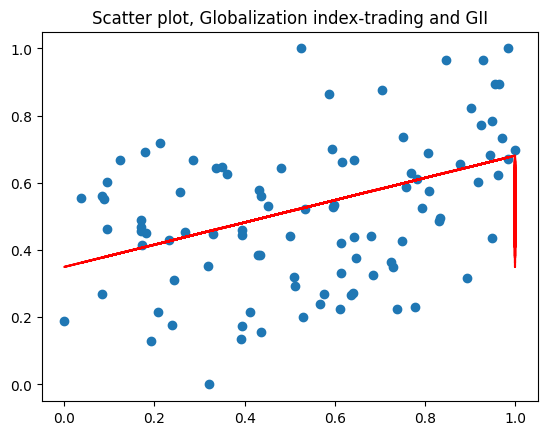

                            OLS Regression Results                            
Dep. Variable:                    GII   R-squared:                       0.235
Model:                            OLS   Adj. R-squared:                  0.215
Method:                 Least Squares   F-statistic:                     11.24
Date:                Mon, 12 Aug 2024   Prob (F-statistic):           5.55e-05
Time:                        17:54:09   Log-Likelihood:                 14.755
No. Observations:                  76   AIC:                            -23.51
Df Residuals:                      73   BIC:                            -16.52
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2900      0.055      5.228      0.0

In [73]:
X = KOF_2015_GII_2018[['Trading']]
y = KOF_2015_GII_2018['GII']
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()

print(model.summary())

plt.scatter(x = KOF_2015_GII_2018['Trading'], y = KOF_2015_GII_2018['GII'])
plt.title("Scatter plot, Globalization index-trading and GII")
plt.plot(X, model.predict(X), color='red')
plt.show()
KOF_2015_GII_2018['Trading'].corr(KOF_2015_GII_2018['GII'])


X = KOF_2015_GII_2018[['Trading', 'Financial']]
y = KOF_2015_GII_2018['GII']
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()

print(model.summary())

# validation

In [50]:
KOF_2015_BTI_major_indices = pd.merge(KOF_2015_economic, major_indices, left_on = 'country', right_on = 'Country')[['Financial', 'SI', 'SII', 'GII', 'SDI', 'PCSDI']]
KOF_2015_BTI_major_indices
scaler = MinMaxScaler(feature_range = (0, 1))
KOF_2015_BTI_major_indices.iloc[:, 1:] = scaler.fit_transform(KOF_2015_BTI_major_indices.iloc[:, 1:])
#multiple regression, because GII was negatively correlated with SDI in our first model along with other indices, we want to know how other indices together would contribute to globalization model
X = KOF_2015_BTI_major_indices[['GII', 'PCSDI']]
y = KOF_2015_BTI_major_indices['Financial']
X = sm.add_constant(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = sm.OLS(y_train, X_train).fit()

print(model.summary())
#because of collenearity of SI and GII, and because PCSDI is insignificant in the model, we can reassure that our finds of positive relation between GII and financial index stands, and that we have considered other factors fully.

                            OLS Regression Results                            
Dep. Variable:              Financial   R-squared:                       0.218
Model:                            OLS   Adj. R-squared:                  0.196
Method:                 Least Squares   F-statistic:                     10.16
Date:                Tue, 23 Jul 2024   Prob (F-statistic):           0.000128
Time:                        00:44:55   Log-Likelihood:                -315.56
No. Observations:                  76   AIC:                             637.1
Df Residuals:                      73   BIC:                             644.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         32.2457      4.661      6.918      0.0

# Segmentation analysis on major indices

In [44]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt


# Prepare the data based on regions
regions = np.sort(major_indices['Region'].unique())[::-1]  # Get unique regions

# Dictionary to store coefficients for each region
coefficients = {}

for region in regions:
    # Filter data for the current region
    region_data = major_indices[major_indices['Region'] == region]
    
    # Define predictors and response variable
    X = region_data[['SI', 'GII', 'PCSDI']]  # Use scaled PCSDI
    y = region_data['SDI']
    
    # Check if the dataset is large enough for training and testing
    if len(X) < 10:  # Example threshold, adjust based on your dataset size
        continue
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize and train the Linear Regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Store the coefficients
    coefficients[region] = model.coef_

# Convert the coefficients to a DataFrame for easier visualization
coef_df = pd.DataFrame(coefficients, index=['SI', 'GII', 'PCSDI_scaled']).T

# Create a heatmap of the coefficients
plt.figure(figsize=(8, 6))
ax = sns.heatmap(coef_df, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Coefficients of Major Indices for Different Regions')
plt.xlabel('Predictors')
plt.ylabel('Regions')
ax.figure.patch.set_facecolor(my_custom_color)
plt.show()

KeyError: 'Region'

In [265]:
major_indices

Country    Region        SI       SII       GII       SDI     PCSDI
0       Albania  0.000000  0.644172  0.649533  0.694570  0.941411  0.736880
1       Algeria  0.500000  0.361963  0.467290  0.454751  0.908123  0.348166
2        Angola  0.666667  0.294479  0.266355  0.303167  0.701731  0.118903
3     Argentina  0.166667  0.760736  0.640187  0.726244  0.885486  0.951643
4       Armenia  0.833333  0.406953  0.574766  0.420814  0.942743  0.655072
..          ...       ...       ...       ...       ...       ...       ...
102  Uzbekistan  0.833333  0.167689  0.345794  0.144796  0.885486  0.654142
103   Venezuela  0.166667  0.245399  0.196262  0.053733  0.794940  0.596245
104       Yemen  0.500000  0.000000  0.000000  0.000000  0.541944  0.237715
105      Zambia  0.666667  0.515337  0.425234  0.520362  0.705726  0.302641
106    Zimbabwe  0.666667  0.249489  0.154206  0.110860  0.687084  0.289978

[105 rows x 7 columns]

# Visualizatiion of major indices in different regions

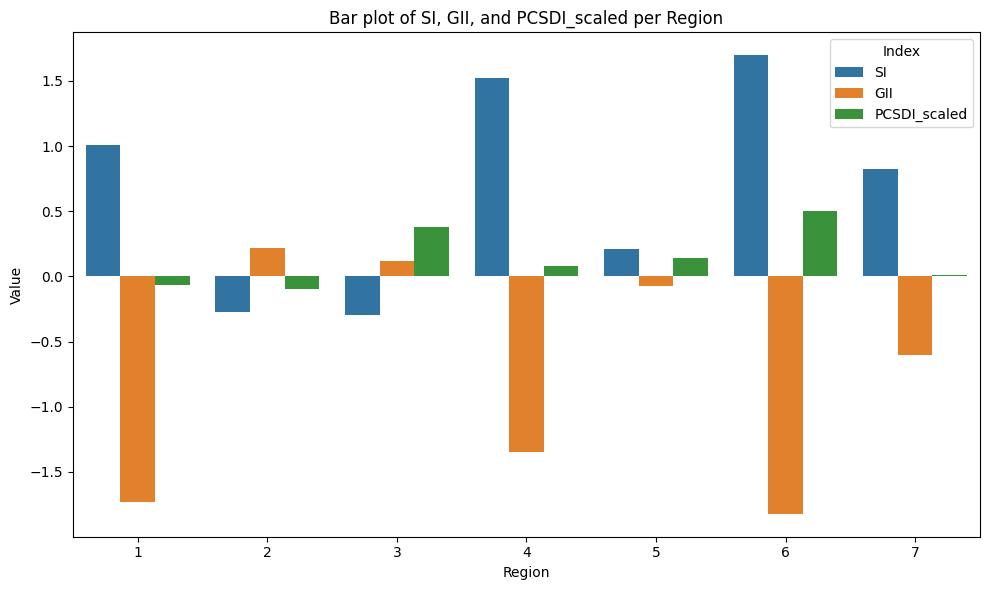

/var/folders/c4/nh07n52n3zb_f772q902yfv00000gn/T/ipykernel_98479/689191434.py:37: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  barplot = sns.barplot(x='Region', y='Value', hue='Index', data=df_long, palette=palette, edgecolor='black')


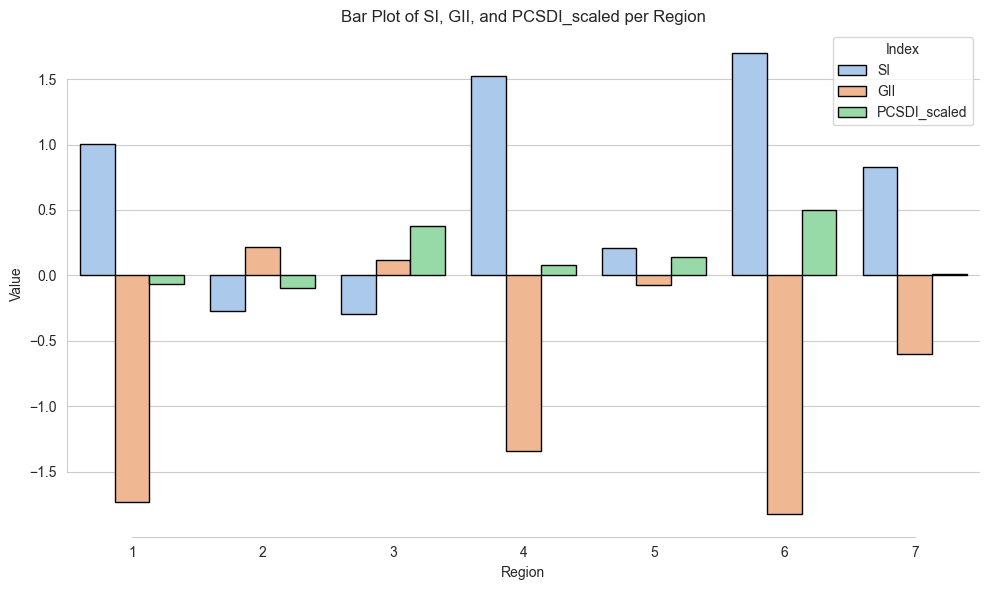

In [278]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df' is your DataFrame

# Transform the DataFrame to long format
df_long = coef_df.reset_index().melt(id_vars='index', var_name='Index', value_name='Value')
df_long.rename(columns={'index': 'Region'}, inplace=True)

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Region', y='Value', hue='Index', data=df_long)

plt.xlabel('Region')
plt.ylabel('Value')
plt.title('Bar plot of SI, GII, and PCSDI_scaled per Region')
plt.legend(title='Index')

plt.tight_layout()
plt.show()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df_long' is your DataFrame in long format

# Set a more aesthetically pleasing style
sns.set_style("whitegrid")

# Choose a color palette
palette = sns.color_palette("pastel")

# Plot using seaborn with the specified palette and bar edges
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Region', y='Value', hue='Index', data=df_long, palette=palette, edgecolor='black')

# Add title and labels
plt.title('Bar Plot of SI, GII, and PCSDI_scaled per Region')
plt.xlabel('Region')
plt.ylabel('Value')

# Enhance legend
plt.legend(title='Index', frameon=True, loc='upper right')

# Despine the plot
sns.despine(trim=True)

# Show the plot
plt.tight_layout()
plt.show()

